# SNR test analysis continued (towards paper-01): 

**Making the analysis shareable and presentable**

Date: 03/29/2023

**Notes**: 

* Hoping this can serve as an basis for how the future ratio analysis can be done.  

## **Imports**

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
import uproot4
from lmfit import minimize, Parameters, fit_report
import lmfit
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Jupyter Lab imports.
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed

# Path to local imports.
sys.path.append("/home/drew/He6CRES/rocks_analysis_pipeline/")
from results import ExperimentResults
from rocks_utility import he6cres_db_query

# Path to local imports.
sys.path.append("/home/drew/He6CRES/he6-cres-spec-sims/")

# Local imports.
import he6_cres_spec_sims.spec_tools.spec_calc.spec_calc as sc
import he6_cres_spec_sims.experiment as exp
import he6_cres_spec_sims.spec_tools.beta_source.beta_spectrum as bs

# Local imports for plotting ratios and such. 
import analysis_functions.ratio_experiment as re
import analysis_functions.ratio_prediction as rp
import analysis_functions.quality_control_methods as qc
import analysis_functions.plotting_methods as pm
import analysis_functions.event_clustering as clust

import mc_functions.simple_mc as mc
import mc_functions.wall_effect as we
import mc_functions.energy_domain as ed
import mc_functions.from_below as fb

## Purpose of Document: 

* Sharing my (Drew) most recent analysis work and current pipeline. 

## Notes: 

* I am only showing the results of the SNR = 9 test for computational ease and because they all seem to trend together. The others can be added into this analysis by uncommenting them in the loading procedure below

## Ideas for Future Work: 

* Say you fit to the max prob of being observed at each cut and see if they are consistent? 
* There is a roll-off in detected tracks with frequency. Why would this be? Think about this and try to incorporate it into the new MC. 
* Just take the ratio in regions with low event rates? How does that look?

## **Step 0: Grab the results from rocks**

### Load Ne19 data

* Not grabbing root files for now. Will do this as a diagnostic if necessary. 

In [3]:
local_dir = "/media/drew/T7 Shield/rocks_analysis/saved_experiments"
include_root_files = False
max_root_files_to_grab = 3
rebuild_experiment_dir = False

snrs = [9]
aids = [26]
# snrs = [8,9,10]
# aids = [25,26,27]
n_files = 100
experiment_names = [f"ne_snr{snr}_fn{n_files}" for snr in snrs]
print(experiment_names)

ne_snr_results = [ ExperimentResults(local_dir = local_dir, 
                                     experiment_name = experiment_name, 
                                     analysis_id = aid, 
                                     include_root_files = include_root_files,
                                     max_root_files_to_grab = max_root_files_to_grab,
                                     rebuild_experiment_dir=rebuild_experiment_dir,
                                    )
                  for (experiment_name, aid) in zip(experiment_names, aids)]


['ne_snr9_fn100']
Keeping existing experiment directory.




### Load He6 data

* Not grabbing root files for now. Will do this as a diagnostic if necessary. 

In [4]:
local_dir = "/media/drew/T7 Shield/rocks_analysis/saved_experiments"
include_root_files = False
max_root_files_to_grab = 3
rebuild_experiment_dir = False


snrs = [9]
aids = [22]
# snrs = [8,9,10]
# aids = [21,22,23]
n_files = 100
experiment_names = [f"he_snr{snr}_fn{n_files}" for snr in snrs]
print(experiment_names)

he_snr_results = [ ExperimentResults(local_dir = local_dir, 
                                     experiment_name = experiment_name, 
                                     analysis_id = aid, 
                                     include_root_files = include_root_files,
                                     max_root_files_to_grab = max_root_files_to_grab,
                                     rebuild_experiment_dir=rebuild_experiment_dir,
                                    )
                  for (experiment_name, aid) in zip(experiment_names, aids)]


['he_snr9_fn100']
Keeping existing experiment directory.




### Build all he and ne results into one dictionary

In [5]:
# Aggregate the results.
snr_cuts = np.array([9])
snr_study = { "ne": dict(zip(snr_cuts,ne_snr_results)),
              "he": dict(zip(snr_cuts,he_snr_results))}

## **Step 1: Another Layer of DBSCAN Clustering.** 

* I need to first apply the cuts that I found were most appropriate. 

### Define the clust_params. Based on testing each field separately. 

**Notes**: 
* I tried to come up with a more quantitative way to decide these epsilons but failed (see below). Ultimately I just looked at the event reconstruction using the quality control tools below. More work could go here, but the finding that there are "too many" Ne counts at low fields or too many He counts at high fields remains regardless of the chosen epsilons. To a limit; if you crank them to .5 or something you break everything. 

#### Epsilon Ideas: 

**Idea**: How to decide this epsilon?

1. What if we scale the epsilon with 1/slope?
    * This didn't work well. Either at low or high fields depending. I also tried scaling it with 1/slope^2. 

In [6]:
features = [ "EventTimeIntc", "EventStartTime"]
set_fields = np.arange(.75,3.5,.25)
epss = np.array([.5,.2,.07,.04,.01,.01, .005, .005, .001, .0001, .0001]) # Verified this is good. 

clust_params = {}

for (set_field, eps) in zip(set_fields, epss): 
    
    clust_params.update({set_field : {"eps":eps}})
    
    if set_field < 1.5: 
        clust_params[set_field].update(  {"features":features} )
    else: 
        clust_params[set_field].update( {"features":["EventTimeIntc"]} )
        
print(clust_params)

{0.75: {'eps': 0.5, 'features': ['EventTimeIntc', 'EventStartTime']}, 1.0: {'eps': 0.2, 'features': ['EventTimeIntc', 'EventStartTime']}, 1.25: {'eps': 0.07, 'features': ['EventTimeIntc', 'EventStartTime']}, 1.5: {'eps': 0.04, 'features': ['EventTimeIntc']}, 1.75: {'eps': 0.01, 'features': ['EventTimeIntc']}, 2.0: {'eps': 0.01, 'features': ['EventTimeIntc']}, 2.25: {'eps': 0.005, 'features': ['EventTimeIntc']}, 2.5: {'eps': 0.005, 'features': ['EventTimeIntc']}, 2.75: {'eps': 0.001, 'features': ['EventTimeIntc']}, 3.0: {'eps': 0.0001, 'features': ['EventTimeIntc']}, 3.25: {'eps': 0.0001, 'features': ['EventTimeIntc']}}


### Drop bad rids, make intial cuts, then cluster. 

**Notes**: 
    * These initial cuts were chosen by looking at the quality control histograms and the reconstruction and making sensible cuts that got rid of anything unphysical. Really the only one of substance is the mTotalSNR > 40 which dealt with some artifitial tracks that were only plaguing SNR=8 for Helium data. It basically cuts no real events.  

In [7]:
both_cuts = {
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (.01, np.inf),
            "mTotalSNR": (40, np.inf),
            "mTotalNUP": (0, np.inf)
            } # This was verified to work 


In [8]:
drop_rid_list = [548, 549, 522, 495, 377]
cluster = True

for isotope in snr_study.keys(): 
    for cut in snr_cuts: 
        
        # Drop bad rids.
        snr_study[isotope][cut].events = snr_study[isotope][cut].events[~snr_study[isotope][cut].events.run_id.isin(drop_rid_list)]
        snr_study[isotope][cut].tracks = snr_study[isotope][cut].tracks[~snr_study[isotope][cut].tracks.run_id.isin(drop_rid_list)]
        snr_study[isotope][cut].root_files = snr_study[isotope][cut].root_files[~snr_study[isotope][cut].root_files.run_id.isin(drop_rid_list)]
        
        # Make initial cuts. Need to do this before clustering or we cluster good events into bad.   
        events = snr_study[isotope][cut].events
        print(f"{isotope}, {cut}.\npre cuts events: {len(events)}")

        # snr_study[isotope][cut].events = re.cut_df(events, both_cuts)
        events_cut = re.cut_df(events, both_cuts)
        snr_study[isotope][cut].events = events_cut
        print(f"\npost cuts events: {len(events_cut)}")
        # Cluster
        if cluster: 
            print(f"pre cluster events: {len(events_cut)} ")
            snr_study[isotope][cut].events = clust.cluster_and_clean_events(events_cut, 
                                                                            clust_params=clust_params,                                                             diagnostics=True)
            print(f"post clust events: {len(snr_study[isotope][cut].events)}")

ne, 9.
pre cuts events: 25852

post cuts events: 25713
pre cluster events: 25713 
Summary of clustring: 


Fractional reduction in counts from clustering: set_field
0.75    0.636364
1.00    0.549211
1.25    0.742535
1.50    0.772117
1.75    0.900029
2.00    0.919952
2.25    0.951281
2.50    0.960513
2.75    0.999336
3.00    0.990237
3.25    0.961702
Name: file_id, dtype: float64

Pre-clustering means:


run_id    file_id   EventID  EventStartTime  EventEndTime  \
set_field                                                                  
0.75       558.306818  44.352273  1.784091        0.414049      0.416054   
1.00       552.833959  47.782870  2.873028        0.502570      0.507645   
1.25       544.019579  50.542340  3.206559        0.499937      0.508976   
1.50       538.006319  49.425750  3.641390        0.502126      0.512325   
1.75       531.979136  49.521298  4.549986        0.496149      0.506502   
2.00       526.033857  49.822491  5.222249        0.492648      0.502383   
2.25       519.480146  49.347508  5.496198        0.491330      0.499206   
2.50       514.027436  48.865641  4.897949        0.488775      0.495346   
2.75       508.006970  50.129771  4.053435        0.497963      0.503331   
3.00       501.947001  51.168061  2.440028        0.488051      0.491940   
3.25       493.719149  51.110638  1.336170        0.514360      0.516885   

           EventStartFreq  EventEndFreq  EventTimeLength  EventFreqLength  \
set_field                                                                   
0.75         5.241321e+08  5.259577e+08         0.002004     1.825561e+06   
1.00         6.141300e+08  6.336925e+08         0.005075     1.956245e+07   
1.25         5.972175e+08  6.733806e+08         0.009039     7.616311e+07   
1.50         5.464735e+08  7.047941e+08         0.010200     1.583206e+08   
1.75         4.983548e+08  7.629970e+08         0.010353     2.646422e+08   
2.00         4.313173e+08  8.124946e+08         0.009735     3.811773e+08   
2.25         4.185042e+08  8.668246e+08         0.007876     4.483205e+08   
2.50         3.892128e+08  9.095324e+08         0.006570     5.203196e+08   
2.75         3.888937e+08  9.602374e+08         0.005368     5.713436e+08   
3.00         4.283323e+08  9.705487e+08         0.003889     5.422164e+08   
3.25         5.622005e+08  1.013138e+09         0.002525     4.509375e+08   

           EventTrackCoverage  ...  mTotalSNR  sTotalSNR    mMaxSNR   sMaxSNR  \
set_field                      ...                                              
0.75                 0.721437  ...  55.478089   7.210083  14.280211  2.108258   
1.00                 0.716881  ...  58.467360   7.997692  15.378098  2.843289   
1.25                 0.731900  ...  60.798996   8.900808  16.116617  3.223128   
1.50                 0.736953  ...  62.188725   9.561855  16.626040  3.513631   
1.75                 0.743943  ...  63.927953  10.319594  17.296673  3.858415   
2.00                 0.750888  ...  64.761313  11.300417  17.569384  4.089194   
2.25                 0.760962  ...  64.631200  10.668847  17.572096  4.054706   
2.50                 0.763833  ...  62.155952  10.167032  16.699191  3.698792   
2.75                 0.780420  ...  59.221871   9.122332  15.675859  3.238704   
3.00                 0.824830  ...  56.186678   8.886496  14.765350  2.803202   
3.25                 0.897984  ...  53.817980   9.402156  14.291633  2.665030   

           mTotalNUP  sTotalNUP  mTotalPower  sTotalPower     field  \
set_field                                                             
0.75       49.248468   6.719154   126.719603    16.736911  0.750159   
1.00       51.742223   7.470390   124.427065    18.978505  1.000200   
1.25       53.947360   8.374535   128.501388    23.871100  1.250300   
1.50       55.298315   9.048719   132.611645    27.540779  1.500324   
1.75       56.963390   9.812044   136.232294    30.762456  1.750366   
2.00       57.787138  10.781671   138.745482    34.514746  2.000402   
2.25       57.606336  10.189993   136.525710    34.451055  2.250432   
2.50       55.222614   9.664552   130.166344    34.158581  2.500450   
2.75       52.344364   8.621611   121.057687    32.344658  2.750550   
3.00       49.407758   8.265011   111.512179    29.894934  3.000437   
3.25       47.000093   8.581370    98.841639    26.921107  3.250479   

           monitor_rate  
set_field           


Pre-clustering stds:


run_id    file_id   EventID  EventStartTime  EventEndTime  \
set_field                                                                
0.75       1.244371  29.092417  1.235945        0.275048      0.274814   
1.00       1.402014  28.498757  2.066114        0.287347      0.287140   
1.25       1.386449  28.660985  2.013037        0.292316      0.292323   
1.50       1.410002  29.064466  2.273860        0.295390      0.295424   
1.75       1.409748  28.793705  2.852618        0.293015      0.293054   
2.00       1.409009  28.777089  3.220142        0.290203      0.290120   
2.25       1.132161  28.791857  3.324586        0.291017      0.291041   
2.50       1.402199  28.549178  2.950536        0.288623      0.288748   
2.75       1.402527  28.603046  2.497568        0.290798      0.290840   
3.00       1.449299  28.503039  1.462092        0.293570      0.293510   
3.25       1.489943  28.973988  0.571557        0.270606      0.270628   

           EventStartFreq  EventEndFreq  EventTimeLength  EventFreqLength  \
set_field                                                                   
0.75         1.821099e+08  1.820479e+08         0.001179     1.348923e+06   
1.00         3.090876e+08  3.081265e+08         0.005052     1.907224e+07   
1.25         3.297001e+08  3.222746e+08         0.008611     7.198472e+07   
1.50         3.390306e+08  3.309725e+08         0.008888     1.370433e+08   
1.75         3.439725e+08  3.376253e+08         0.008470     2.152700e+08   
2.00         3.359705e+08  3.414922e+08         0.007183     2.798964e+08   
2.25         3.355022e+08  3.271356e+08         0.005633     3.193115e+08   
2.50         3.240363e+08  3.073220e+08         0.004262     3.362939e+08   
2.75         3.105207e+08  2.679312e+08         0.003126     3.318022e+08   
3.00         2.945903e+08  2.403956e+08         0.002332     3.248631e+08   
3.25         2.966095e+08  1.872752e+08         0.001570     2.799858e+08   

           EventTrackCoverage  ...  mTotalSNR  sTotalSNR   mMaxSNR   sMaxSNR  \
set_field                      ...                                             
0.75                 0.142552  ...   3.950531   4.001807  1.279182  0.997504   
1.00                 0.110772  ...   7.027006   2.952950  2.134316  1.105384   
1.25                 0.099461  ...   8.137705   3.092460  2.601159  1.221303   
1.50                 0.100413  ...   8.590428   3.189285  2.786732  1.328195   
1.75                 0.113014  ...   9.074271   3.442328  3.025638  1.469373   
2.00                 0.110049  ...   8.946962   3.943887  2.905495  1.474849   
2.25                 0.102481  ...   8.213207   3.362998  2.784246  1.408466   
2.50                 0.103395  ...   6.896535   2.939171  2.236693  1.209893   
2.75                 0.109978  ...   5.645444   2.544373  1.769650  1.031497   
3.00                 0.139620  ...   4.777792   2.608255  1.387769  0.926522   
3.25                 0.155057  ...   4.431743   2.808450  1.224106  0.945918   

           mTotalNUP  sTotalNUP  mTotalPower  sTotalPower     field  \
set_field                                                             
0.75        3.769846   3.600781    29.084741    10.818955  0.000007   
1.00        6.811033   2.715326    40.017683     8.642396  0.000005   
1.25        7.922331   2.940644    40.387209     9.598057  0.000003   
1.50        8.365189   3.085537    40.691737     9.841181  0.000007   
1.75        8.825095   3.353133    40.914860    10.984674  0.000003   
2.00        8.641494   3.871058    38.260838    12.300689  0.000006   
2.25        7.948207   3.282777    35.747691    11.804376  0.000009   
2.50        6.638198   2.849860    30.840218    11.330627  0.000005   
2.75        5.392322   2.403806    25.940648    10.351298  0.000006   
3.00        4.489352   2.375018    22.244062    10.066782  0.000006   
3.25        4.149412   2.491034    19.758730     9.514868  0.000013   

           monitor_rate  
set_field                
0.75         480.024768  
1.00 


Post-clustering means:


run_id    file_id   EventID  EventStartTime  EventEndTime  \
set_field                                                                  
0.75       558.392857  43.053571  1.089286        0.443034      0.452035   
1.00       552.842681  47.793434  1.575923        0.488796      0.515966   
1.25       544.013184  50.844430  2.405405        0.498657      0.513577   
1.50       538.017903  49.436317  2.814834        0.494468      0.511533   
1.75       531.998390  49.403735  4.096909        0.496742      0.508537   
2.00       526.039432  49.757886  4.824132        0.491093      0.501459   
2.25       519.486382  49.232682  5.208407        0.491127      0.499221   
2.50       514.026428  48.861452  4.703951        0.488864      0.495585   
2.75       508.007307  50.133510  4.043175        0.498081      0.503450   
3.00       501.940845  51.210563  2.436620        0.487816      0.491748   
3.25       493.743363  51.269912  1.305310        0.511371      0.514020   

           EventStartFreq  EventEndFreq  EventTimeLength  EventFreqLength  \
set_field                                                                   
0.75         5.201517e+08  5.255225e+08         0.009001     5.370757e+06   
1.00         5.613823e+08  6.593922e+08         0.027170     9.800984e+07   
1.25         5.543260e+08  6.824582e+08         0.014920     1.281322e+08   
1.50         4.892494e+08  7.301616e+08         0.017064     2.409122e+08   
1.75         4.648412e+08  7.649854e+08         0.011795     3.001442e+08   
2.00         4.186824e+08  8.221989e+08         0.010366     4.035166e+08   
2.25         4.122839e+08  8.721538e+08         0.008094     4.598699e+08   
2.50         3.857141e+08  9.157257e+08         0.006722     5.300116e+08   
2.75         3.889717e+08  9.604148e+08         0.005369     5.714432e+08   
3.00         4.271027e+08  9.753045e+08         0.003932     5.482018e+08   
3.25         5.541265e+08  1.027267e+09         0.002650     4.731405e+08   

           EventTrackCoverage  ...  mTotalSNR  sTotalSNR    mMaxSNR   sMaxSNR  \
set_field                      ...                                              
0.75                 0.717166  ...  55.285675   7.320023  14.242453  2.025346   
1.00                 0.720416  ...  58.727578   8.045826  15.444720  2.863094   
1.25                 0.737345  ...  61.495602   9.012701  16.337597  3.322550   
1.50                 0.740864  ...  62.924844   9.686775  16.855325  3.615049   
1.75                 0.745419  ...  64.259600  10.390062  17.406244  3.903530   
2.00                 0.751804  ...  64.860630  11.306454  17.595916  4.102315   
2.25                 0.761372  ...  64.666779  10.663468  17.583452  4.058976   
2.50                 0.763943  ...  62.160782  10.157453  16.699515  3.699789   
2.75                 0.780453  ...  59.222581   9.121866  15.675901  3.238896   
3.00                 0.825290  ...  56.212790   8.900255  14.773147  2.808955   
3.25                 0.899913  ...  53.928762   9.371080  14.299715  2.675830   

           mTotalNUP  sTotalNUP  mTotalPower  sTotalPower     field  \
set_field                                                             
0.75       49.067781   6.798298   126.897413    17.194035  0.750160   
1.00       52.008350   7.525799   125.596303    19.251388  1.000200   
1.25       54.654361   8.505225   131.512534    24.448251  1.250300   
1.50       56.033867   9.192664   135.664251    28.057652  1.500324   
1.75       57.307230   9.889491   137.978828    31.151765  1.750366   
2.00       57.881958  10.790561   139.040757    34.539471  2.000402   
2.25       57.639123  10.185659   136.595113    34.413342  2.250432   
2.50       55.223014   9.656729   130.051080    34.113597  2.500450   
2.75       52.344746   8.621225   121.049315    32.342765  2.750550   
3.00       49.428309   8.278302   111.417406    29.932030  3.000437   
3.25       47.095678   8.560681    98.924196    27.007979  3.250479   

           monitor_rate  
set_field           


Post-clustering stds:


run_id    file_id   EventID  EventStartTime  EventEndTime  \
set_field                                                                
0.75       1.316726  30.520586  0.287736        0.288971      0.289702   
1.00       1.414653  28.436659  0.757190        0.292020      0.291931   
1.25       1.389685  28.943390  1.367179        0.294755      0.294794   
1.50       1.409206  28.650604  1.593386        0.298643      0.299046   
1.75       1.407250  28.813475  2.497911        0.293933      0.293907   
2.00       1.412175  28.802820  2.943474        0.290761      0.290733   
2.25       1.131281  28.708335  3.093225        0.291441      0.291465   
2.50       1.401543  28.506983  2.812175        0.288809      0.288932   
2.75       1.402873  28.608204  2.489605        0.290856      0.290898   
3.00       1.449899  28.489258  1.465433        0.294377      0.294319   
3.25       1.504239  28.902482  0.565425        0.271990      0.272049   

           EventStartFreq  EventEndFreq  EventTimeLength  EventFreqLength  \
set_field                                                                   
0.75         1.913820e+08  1.903891e+08         0.038902     1.000742e+07   
1.00         3.069538e+08  3.069005e+08         0.049077     1.697605e+08   
1.25         3.268717e+08  3.243342e+08         0.016124     1.398360e+08   
1.50         3.273338e+08  3.315202e+08         0.019121     2.242340e+08   
1.75         3.293747e+08  3.393822e+08         0.009527     2.354299e+08   
2.00         3.325739e+08  3.408018e+08         0.007516     2.871589e+08   
2.25         3.345148e+08  3.267091e+08         0.005732     3.232777e+08   
2.50         3.237245e+08  3.058331e+08         0.004327     3.384075e+08   
2.75         3.106046e+08  2.677855e+08         0.003126     3.318123e+08   
3.00         2.949467e+08  2.356765e+08         0.002323     3.235254e+08   
3.25         2.990979e+08  1.750645e+08         0.001579     2.815861e+08   

           EventTrackCoverage  ...  mTotalSNR  sTotalSNR   mMaxSNR   sMaxSNR  \
set_field                      ...                                             
0.75                 0.137464  ...   3.713661   3.740661  1.168239  0.839646   
1.00                 0.093133  ...   6.278620   2.499035  1.922084  0.964778   
1.25                 0.089022  ...   7.688620   2.891600  2.480245  1.140948   
1.50                 0.089687  ...   8.043232   3.040306  2.645792  1.252014   
1.75                 0.110363  ...   8.828052   3.323918  2.953625  1.423971   
2.00                 0.105984  ...   8.723202   3.865638  2.845192  1.443080   
2.25                 0.098958  ...   8.068715   3.315735  2.736803  1.390011   
2.50                 0.102188  ...   6.815848   2.921507  2.212999  1.198404   
2.75                 0.109846  ...   5.645291   2.544760  1.769760  1.031343   
3.00                 0.139327  ...   4.771206   2.575072  1.385661  0.922555   
3.25                 0.155877  ...   4.316552   2.789687  1.184512  0.924661   

           mTotalNUP  sTotalNUP  mTotalPower  sTotalPower     field  \
set_field                                                             
0.75        3.464860   3.344652    28.982649    10.704712  0.000007   
1.00        6.095797   2.296950    36.722811     7.588295  0.000005   
1.25        7.488780   2.777057    38.943803     9.057607  0.000004   
1.50        7.842096   2.956326    38.955706     9.352161  0.000007   
1.75        8.561376   3.247685    39.681531    10.646865  0.000003   
2.00        8.426155   3.796064    37.723521    12.004128  0.000006   
2.25        7.808984   3.235773    35.453671    11.627712  0.000009   
2.50        6.565919   2.831533    30.705475    11.263596  0.000005   
2.75        5.392534   2.404059    25.944775    10.350605  0.000006   
3.00        4.486631   2.343970    22.121906    10.033352  0.000006   
3.25        4.063052   2.475174    19.329917     9.492992  0.000013   

           monitor_rate  
set_field                
0.75         506.661676  
1.00 

post clust events: 22950
he, 9.
pre cuts events: 44963

post cuts events: 44686
pre cluster events: 44686 
Summary of clustring: 


Fractional reduction in counts from clustering: set_field
0.75    0.500000
1.00    0.729569
1.25    0.825048
1.50    0.823357
1.75    0.922297
2.00    0.921345
2.25    0.940950
2.50    0.924208
2.75    0.999881
3.00    1.000000
3.25    1.000000
Name: file_id, dtype: float64

Pre-clustering means:


run_id    file_id    EventID  EventStartTime  EventEndTime  \
set_field                                                                   
0.75       437.920635  49.246032   2.182540        0.544181      0.548336   
1.00       431.901932  50.353640   1.955423        0.500595      0.510934   
1.25       425.977055  50.688337   2.137667        0.492732      0.503672   
1.50       420.019366  50.378521   2.859155        0.497396      0.508919   
1.75       413.637012  47.348724   3.553679        0.504250      0.514511   
2.00       407.045023  48.618931   4.796854        0.489629      0.499069   
2.25       400.963070  49.613003   6.316215        0.491453      0.499584   
2.50       395.015413  49.000566   8.228083        0.498534      0.505296   
2.75       389.018320  49.624792   9.567333        0.496005      0.501823   
3.00       383.003172  49.622808  11.057773        0.495791      0.500486   
3.25       374.434975  49.663054  11.615887        0.494880      0.498763   

           EventStartFreq  EventEndFreq  EventTimeLength  EventFreqLength  \
set_field                                                                   
0.75         6.050712e+08  6.080495e+08         0.004155     2.978322e+06   
1.00         6.173033e+08  6.548485e+08         0.010340     3.754523e+07   
1.25         5.609554e+08  6.521568e+08         0.010940     9.120136e+07   
1.50         5.548353e+08  7.317790e+08         0.011522     1.769436e+08   
1.75         5.072102e+08  7.688861e+08         0.010261     2.616759e+08   
2.00         4.433890e+08  8.125883e+08         0.009440     3.691993e+08   
2.25         3.855797e+08  8.478359e+08         0.008132     4.622562e+08   
2.50         3.542593e+08  8.886283e+08         0.006762     5.343690e+08   
2.75         3.155659e+08  9.340347e+08         0.005818     6.184688e+08   
3.00         3.045678e+08  9.577841e+08         0.004695     6.532163e+08   
3.25         2.829569e+08  9.743277e+08         0.003884     6.913709e+08   

           EventTrackCoverage  ...  mTotalSNR  sTotalSNR    mMaxSNR   sMaxSNR  \
set_field                      ...                                              
0.75                 0.630209  ...  56.221117   7.283351  14.702987  2.621043   
1.00                 0.693220  ...  61.537010   8.675064  16.391357  3.295527   
1.25                 0.746623  ...  65.413207  10.353785  17.734129  3.853648   
1.50                 0.760564  ...  67.461125  11.121772  18.486051  4.244252   
1.75                 0.772503  ...  68.775646  11.895522  19.090580  4.555649   
2.00                 0.782011  ...  69.996414  13.580334  19.411563  4.893206   
2.25                 0.788551  ...  69.335530  12.408300  19.321435  4.811729   
2.50                 0.807345  ...  66.138266  11.856619  18.174529  4.381981   
2.75                 0.858489  ...  62.976948  10.652263  17.056872  3.897673   
3.00                 0.913069  ...  59.289758  10.236728  15.937226  3.427754   
3.25                 0.989017  ...  56.434354  10.087188  15.124754  3.074971   

           mTotalNUP  sTotalNUP  mTotalPower  sTotalPower     field  \
set_field                                                             
0.75       48.822642   6.662126    95.555004    12.609139  0.749927   
1.00       53.728710   8.046096   105.266198    17.082737  0.999979   
1.25       57.554954   9.696608   115.441999    21.864027  1.250020   
1.50       59.327322  10.452838   115.310958    23.619979  1.500065   
1.75       60.604905  11.197789   118.168254    26.219737  1.750088   
2.00       61.790118  12.825489   120.749499    29.995065  2.000091   
2.25       61.197682  11.736291   120.186528    29.705882  2.250095   
2.50       58.174083  11.173281   113.652709    29.313027  2.500082   
2.75       55.171254  10.015325   107.153036    28.319948  2.750004   
3.00       51.710202   9.505388    99.690743    27.212373  2.999901   
3.25       49.070134   9.255928    94.380763    26.688925  3.249961   

           monitor_rate  
set_fie


Pre-clustering stds:


run_id    file_id   EventID  EventStartTime  EventEndTime  \
set_field                                                                
0.75       1.417622  27.023156  1.444442        0.261876      0.261803   
1.00       1.423405  28.604233  1.299418        0.279716      0.279422   
1.25       1.379775  29.300104  1.302987        0.285853      0.285279   
1.50       1.399681  28.932128  1.851218        0.291508      0.291455   
1.75       1.741455  28.549928  2.176956        0.289576      0.289928   
2.00       1.380875  28.710823  2.964469        0.289142      0.289159   
2.25       1.430640  28.577111  3.832541        0.289980      0.289813   
2.50       1.408468  29.293829  4.985981        0.289482      0.289487   
2.75       1.434228  28.947672  5.797530        0.287863      0.287839   
3.00       0.816388  28.720886  6.601274        0.289195      0.289149   
3.25       1.115327  29.182751  6.956173        0.287420      0.287391   

           EventStartFreq  EventEndFreq  EventTimeLength  EventFreqLength  \
set_field                                                                   
0.75         2.779036e+08  2.771887e+08         0.004063     3.126582e+06   
1.00         3.223971e+08  3.192013e+08         0.008663     3.120029e+07   
1.25         3.361032e+08  3.351397e+08         0.008949     7.381773e+07   
1.50         3.473204e+08  3.413335e+08         0.008951     1.362357e+08   
1.75         3.557980e+08  3.483429e+08         0.008400     2.125272e+08   
2.00         3.444210e+08  3.488522e+08         0.007138     2.771493e+08   
2.25         3.319894e+08  3.440374e+08         0.005738     3.246750e+08   
2.50         3.190889e+08  3.284137e+08         0.004393     3.450663e+08   
2.75         2.932616e+08  3.012575e+08         0.003296     3.482561e+08   
3.00         2.755094e+08  2.721487e+08         0.002445     3.375664e+08   
3.25         2.458419e+08  2.433606e+08         0.001817     3.202247e+08   

           EventTrackCoverage  ...  mTotalSNR  sTotalSNR   mMaxSNR   sMaxSNR  \
set_field                      ...                                             
0.75                 0.154229  ...   4.986881   3.452013  1.627541  1.047206   
1.00                 0.116868  ...   8.326384   2.908634  2.675291  1.132068   
1.25                 0.092756  ...  11.051857   3.813745  3.601255  1.485630   
1.50                 0.087768  ...  11.629112   4.120178  3.898289  1.621230   
1.75                 0.106091  ...  12.102014   4.326096  4.169713  1.807641   
2.00                 0.107101  ...  11.667111   5.527447  3.874335  1.868127   
2.25                 0.109166  ...  10.790345   4.263420  3.798541  1.762084   
2.50                 0.134301  ...   9.322681   3.848224  3.099769  1.526413   
2.75                 0.168441  ...   7.586529   3.026903  2.484061  1.300060   
3.00                 0.199680  ...   6.055932   2.651524  1.858765  1.078450   
3.25                 0.210262  ...   4.955669   2.395424  1.442838  0.914951   

           mTotalNUP  sTotalNUP  mTotalPower  sTotalPower     field  \
set_field                                                             
0.75        4.607012   2.978835    26.416168     7.485137  0.000004   
1.00        8.014058   2.735939    34.692982     7.451470  0.000005   
1.25       10.570199   3.669237    37.875526     8.767873  0.000007   
1.50       11.221867   3.971249    39.056627     9.094709  0.000006   
1.75       11.594204   4.167461    38.250316     9.836442  0.000007   
2.00       11.137086   5.331991    36.232965    11.861270  0.000007   
2.25       10.288201   4.116487    33.294743    10.559787  0.000007   
2.50        8.857055   3.717139    28.997600    10.053049  0.000007   
2.75        7.163186   2.913529    23.751650     8.732210  0.000004   
3.00        5.667068   2.481251    19.562346     7.824460  0.000007   
3.25        4.563028   2.190260    15.860587     7.084898  0.000011   

           monitor_rate  
set_field                
0.75        1169.167278  
1.00 


Post-clustering means:


run_id    file_id    EventID  EventStartTime  EventEndTime  \
set_field                                                                   
0.75       438.015873  45.603175   1.079365        0.545742      0.559482   
1.00       431.947047  49.684318   1.397149        0.484017      0.505757   
1.25       425.976825  49.888760   1.783314        0.488137      0.502815   
1.50       420.031361  50.030649   2.334996        0.495645      0.512532   
1.75       413.627188  47.249491   3.298738        0.501139      0.512513   
2.00       407.035914  48.421548   4.404769        0.488992      0.499062   
2.25       400.958913  49.762265   5.937449        0.492586      0.500980   
2.50       395.018207  48.982405   7.581701        0.497343      0.504397   
2.75       389.018322  49.629387   9.547650        0.496044      0.501863   
3.00       383.003172  49.622808  11.027217        0.495791      0.500486   
3.25       374.434975  49.663054  11.508990        0.494880      0.498763   

           EventStartFreq  EventEndFreq  EventTimeLength  EventFreqLength  \
set_field                                                                   
0.75         5.755852e+08  5.929194e+08         0.013740     1.733419e+07   
1.00         5.863644e+08  6.715648e+08         0.021741     8.520036e+07   
1.25         5.477124e+08  6.705034e+08         0.014679     1.227910e+08   
1.50         5.067464e+08  7.465069e+08         0.016887     2.397604e+08   
1.75         4.825898e+08  7.711425e+08         0.011374     2.885527e+08   
2.00         4.307179e+08  8.247859e+08         0.010070     3.940680e+08   
2.25         3.803714e+08  8.558000e+08         0.008394     4.754286e+08   
2.50         3.465013e+08  8.987312e+08         0.007054     5.522299e+08   
2.75         3.154966e+08  9.340054e+08         0.005819     6.185088e+08   
3.00         3.045678e+08  9.577841e+08         0.004695     6.532163e+08   
3.25         2.829569e+08  9.743277e+08         0.003884     6.913709e+08   

           EventTrackCoverage  ...  mTotalSNR  sTotalSNR    mMaxSNR   sMaxSNR  \
set_field                      ...                                              
0.75                 0.620880  ...  55.710321   7.547516  14.663938  2.616307   
1.00                 0.689587  ...  62.267216   8.827663  16.618139  3.391428   
1.25                 0.751428  ...  66.564085  10.538656  18.088508  3.998178   
1.50                 0.764235  ...  68.302078  11.346022  18.756034  4.353006   
1.75                 0.775455  ...  69.381040  12.009310  19.284613  4.632685   
2.00                 0.782574  ...  70.177361  13.620557  19.469970  4.916868   
2.25                 0.788822  ...  69.427194  12.416988  19.350969  4.823410   
2.50                 0.808350  ...  66.233086  11.867991  18.202599  4.393743   
2.75                 0.858479  ...  62.976988  10.652241  17.056911  3.897598   
3.00                 0.913069  ...  59.289758  10.236728  15.937226  3.427754   
3.25                 0.989017  ...  56.434354  10.087188  15.124754  3.074971   

           mTotalNUP  sTotalNUP  mTotalPower  sTotalPower     field  \
set_field                                                             
0.75       48.327613   6.865691    94.172040    12.742404  0.749927   
1.00       54.427697   8.209625   106.508822    17.340997  0.999979   
1.25       58.622866   9.898361   117.186521    22.241962  1.250020   
1.50       60.165804  10.684257   117.889320    24.245212  1.500065   
1.75       61.198706  11.320953   119.815942    26.594761  1.750088   
2.00       61.955593  12.866885   120.988565    30.070771  2.000091   
2.25       61.274268  11.746529   120.185503    29.713994  2.250095   
2.50       58.256494  11.187553   113.711356    29.313817  2.500082   
2.75       55.171378  10.015303   107.154953    28.320435  2.750004   
3.00       51.710202   9.505388    99.690743    27.212373  2.999901   
3.25       49.070134   9.255928    94.380763    26.688925  3.249961   

           monitor_rate  
set_fie


Post-clustering stds:


run_id    file_id   EventID  EventStartTime  EventEndTime  \
set_field                                                                
0.75       1.486412  27.254203  0.272479        0.270847      0.268724   
1.00       1.433294  28.684991  0.660173        0.280007      0.281273   
1.25       1.379135  29.208057  0.956405        0.291461      0.290976   
1.50       1.397119  29.081514  1.317216        0.291852      0.291078   
1.75       1.740084  28.676933  1.992323        0.290149      0.290579   
2.00       1.380243  28.685782  2.648557        0.289631      0.289667   
2.25       1.430081  28.521291  3.560812        0.289827      0.289673   
2.50       1.406447  29.285088  4.521687        0.289963      0.289982   
2.75       1.434314  28.946328  5.781955        0.287858      0.287833   
3.00       0.816388  28.720886  6.580631        0.289195      0.289149   
3.25       1.115327  29.182751  6.890209        0.287420      0.287391   

           EventStartFreq  EventEndFreq  EventTimeLength  EventFreqLength  \
set_field                                                                   
0.75         2.865720e+08  2.865299e+08         0.031293     5.197233e+07   
1.00         3.151505e+08  3.101736e+08         0.033095     1.303552e+08   
1.25         3.340105e+08  3.298815e+08         0.013871     1.136465e+08   
1.50         3.338042e+08  3.410945e+08         0.017316     2.032388e+08   
1.75         3.456012e+08  3.495686e+08         0.009374     2.272652e+08   
2.00         3.401462e+08  3.462749e+08         0.007497     2.881425e+08   
2.25         3.309650e+08  3.427896e+08         0.005841     3.276410e+08   
2.50         3.162103e+08  3.256299e+08         0.004515     3.474210e+08   
2.75         2.932102e+08  3.012635e+08         0.003297     3.482575e+08   
3.00         2.755094e+08  2.721487e+08         0.002445     3.375664e+08   
3.25         2.458419e+08  2.433606e+08         0.001817     3.202247e+08   

           EventTrackCoverage  ...  mTotalSNR  sTotalSNR   mMaxSNR   sMaxSNR  \
set_field                      ...                                             
0.75                 0.148564  ...   5.307225   3.233505  1.521525  1.058927   
1.00                 0.112361  ...   8.036392   2.597787  2.594703  1.052008   
1.25                 0.081428  ...  10.465111   3.665828  3.454357  1.398497   
1.50                 0.080753  ...  11.098848   3.953227  3.747864  1.548843   
1.75                 0.100042  ...  11.778841   4.250362  4.093220  1.759144   
2.00                 0.102202  ...  11.372587   5.437652  3.784694  1.831375   
2.25                 0.104887  ...  10.560964   4.192730  3.726337  1.729043   
2.50                 0.130170  ...   9.050329   3.759843  3.017891  1.489253   
2.75                 0.168448  ...   7.586121   3.026663  2.483897  1.299988   
3.00                 0.199680  ...   6.055932   2.651524  1.858765  1.078450   
3.25                 0.210262  ...   4.955669   2.395424  1.442838  0.914951   

           mTotalNUP  sTotalNUP  mTotalPower  sTotalPower     field  \
set_field                                                             
0.75        4.826420   2.725216    25.780813     6.582371  0.000003   
1.00        7.771277   2.474569    33.466318     6.697683  0.000005   
1.25       10.051149   3.545765    37.314750     8.357782  0.000007   
1.50       10.701586   3.821483    37.562532     8.693101  0.000006   
1.75       11.265874   4.095974    37.282891     9.628474  0.000007   
2.00       10.865004   5.248427    35.782767    11.661014  0.000007   
2.25       10.077944   4.047371    33.097537    10.414120  0.000007   
2.50        8.603631   3.633333    28.631209     9.879455  0.000007   
2.75        7.162645   2.913276    23.749566     8.730695  0.000004   
3.00        5.667068   2.481251    19.562346     7.824460  0.000007   
3.25        4.563028   2.190260    15.860587     7.084898  0.000011   

           monitor_rate  
set_field                
0.75        1136.712583  
1.00 

post clust events: 42616


## **Step 2: Run quality control tests.** 

* Add in the ability to cut certain run_ids from the datasets. See if necessary first. 
* Make a "Data quality function" that prints out some key metrics from the run. 

### Building list of permanent cuts based on below quality control tests. 

**Ne:** 
* Drop 548, 549, 522, 495. These have no counts at all and should. 
* Cuts to make: 
    * EventTimeLength < .5
    * EventFreqIntc > -2e11
    * EventTimeIntc > -.5e7
    * EventSlope > .2e10
    * For .75, 1.0 T: 
        



**He:** 
* Drop 377. This has too many counts for 8 and no counts for the rest.
* Cuts to make: 
    * snr8, .75, 1.0 T are weird. Need to do some custom cuts on those. 
    * 8 (.75, 1.0, 1.25,1.5, 1.75, 2.0): Note these could apply to the other snr cuts as well. 
        * mTotalSNR > 39
        * TotTrackCoverage >.25
        * mTotalNUP > 35

### QC Test 0: Investigate the run_ids present in the analysis for the events df and the root_files df.

**Note:** This is also a way to test the CRES vs monitor rate linearity. There is only an entry in the events df if there was an event detected. Be careful for cases when there are (incorrectly) no events identified in a run_id as this will mess with the normalization. 


 ne_9: List of run_ids vs set_field in events df
    set_field                     run_id
0        0.75  [557, 558, 559, 560, 561]
1        1.00  [551, 552, 553, 554, 555]
2        1.25  [542, 543, 544, 545, 546]
3        1.50  [536, 537, 538, 539, 540]
4        1.75  [530, 531, 532, 533, 534]
5        2.00  [524, 525, 526, 527, 528]
6        2.25       [518, 519, 520, 521]
7        2.50  [512, 513, 514, 515, 516]
8        2.75  [506, 507, 508, 509, 510]
9        3.00  [500, 501, 502, 503, 504]
10       3.25       [492, 493, 494, 496]



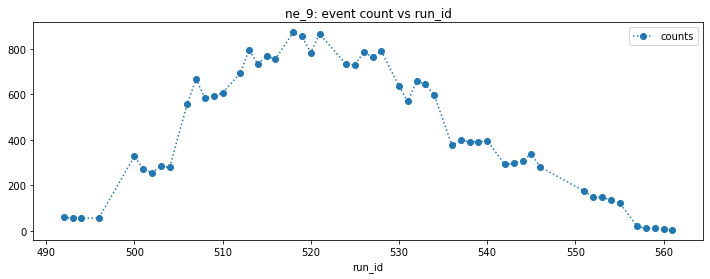

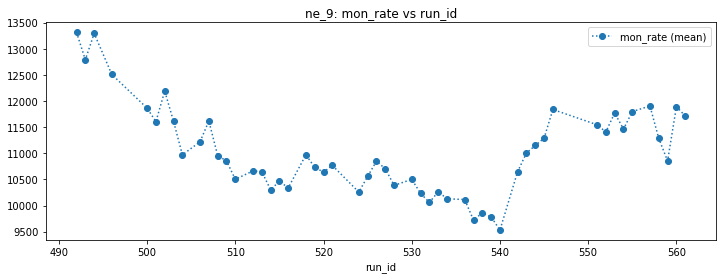

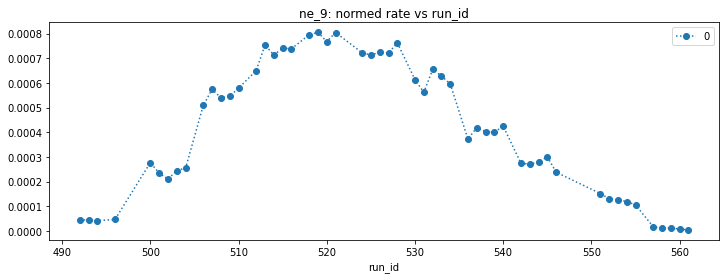


 he_9: List of run_ids vs set_field in events df
    set_field                          run_id
0        0.75       [436, 437, 438, 439, 440]
1        1.00       [430, 431, 432, 433, 434]
2        1.25       [424, 425, 426, 427, 428]
3        1.50       [418, 419, 420, 421, 422]
4        1.75  [411, 412, 413, 414, 415, 416]
5        2.00       [405, 406, 407, 408, 409]
6        2.25       [399, 400, 401, 402, 403]
7        2.50       [393, 394, 395, 396, 397]
8        2.75       [387, 388, 389, 390, 391]
9        3.00                 [382, 383, 384]
10       3.25            [373, 374, 375, 376]



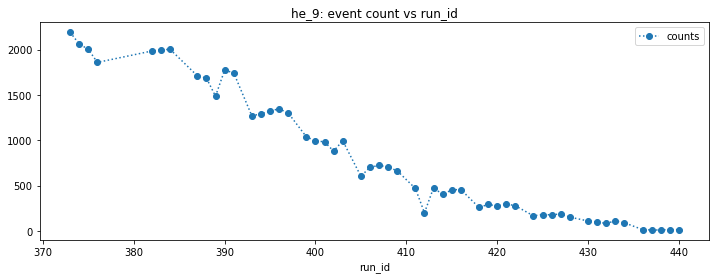

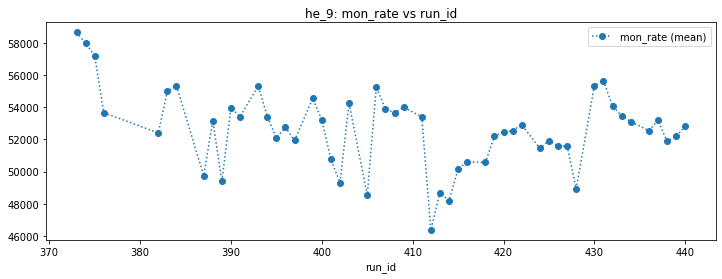

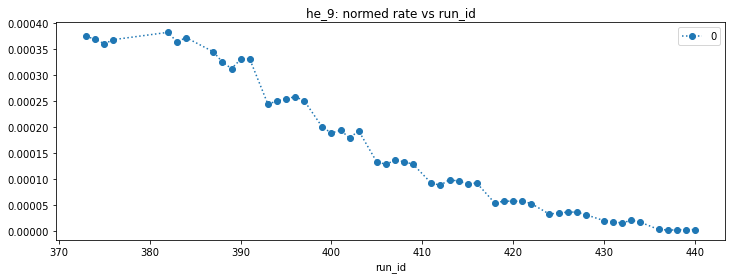

In [9]:
%matplotlib inline
for isotope in snr_study.keys(): 
    for cut in snr_cuts: 
        qc.events_summary(snr_study[isotope][cut].events,
                          snr_study[isotope][cut].root_files,
                          title = f"{isotope}_{cut}")
        # Uncomment the below to look at the normalization used for building spectra
        # display(re.build_normalization(snr_study[isotope][cut].root_files))

### QC Test 1: Histogram event attributes.

Notes: Keep an eye out for outliers. 

In [10]:
both_cuts = {
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (.01, np.inf),
            "mTotalSNR": (40, np.inf),
            "mTotalNUP": (0, np.inf)
            }

additional_cuts = {
                "EventStartFreq": (200e6, 1200e6),
                "EventNBins": (0, np.inf),
                }
ne_cuts = {**both_cuts, **additional_cuts}
he_cuts = {**both_cuts, **additional_cuts}

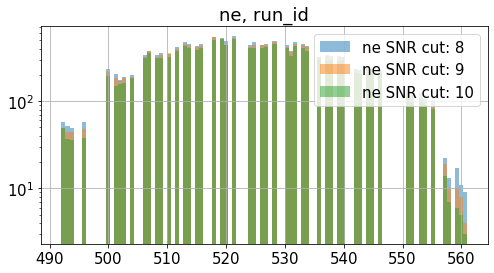

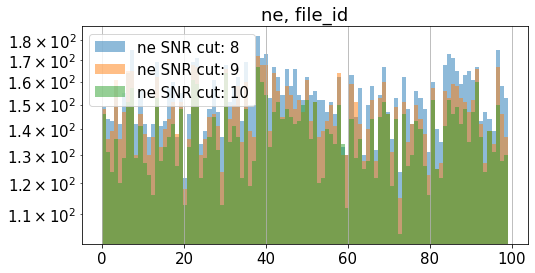

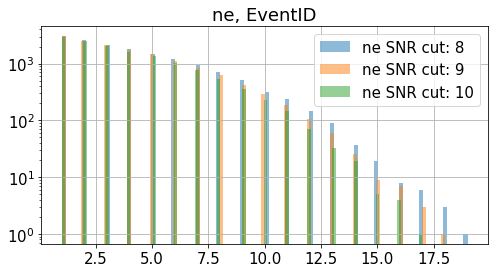

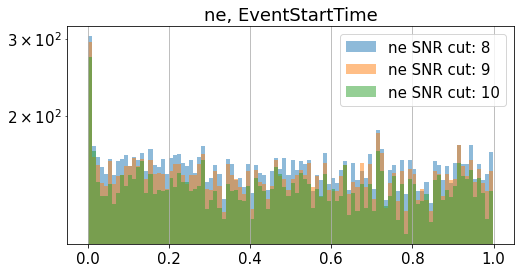

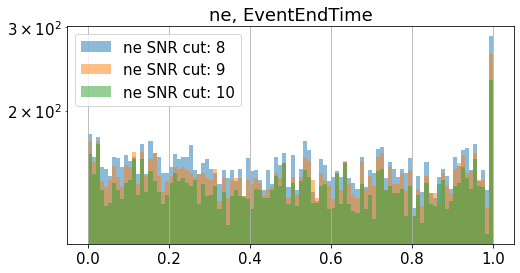

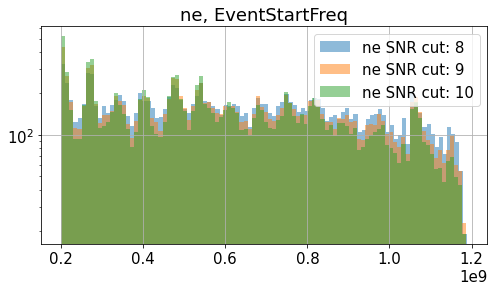

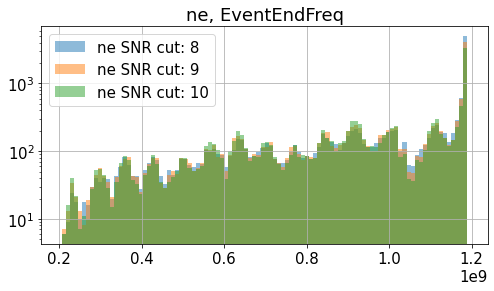

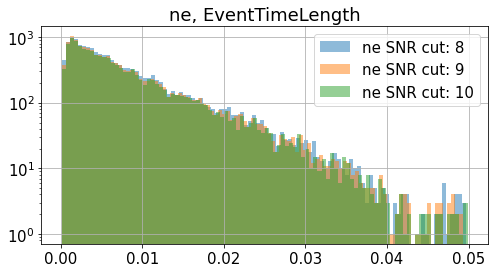

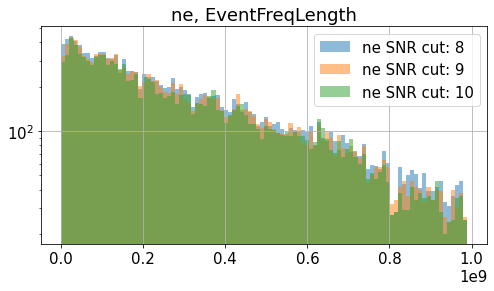

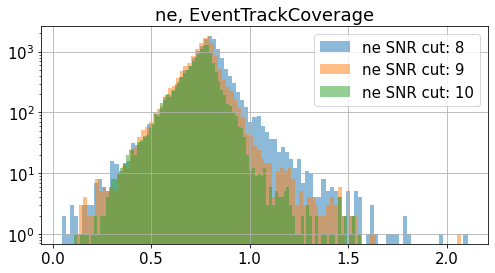

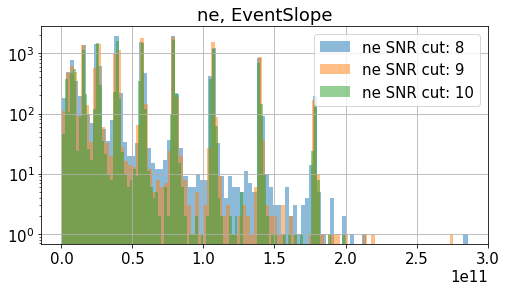

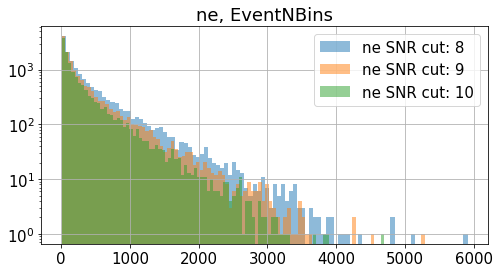

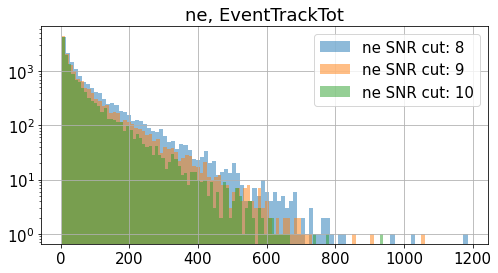

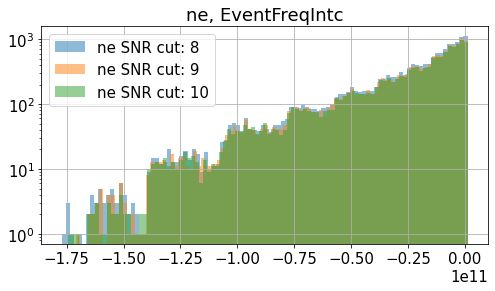

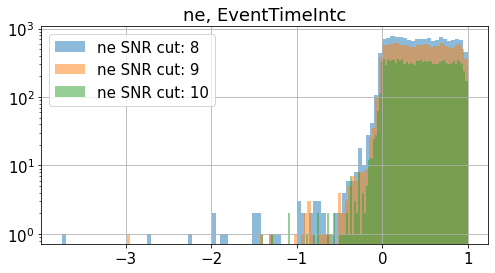

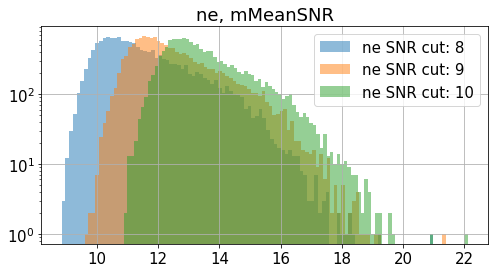

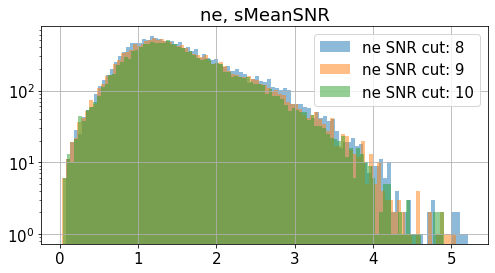

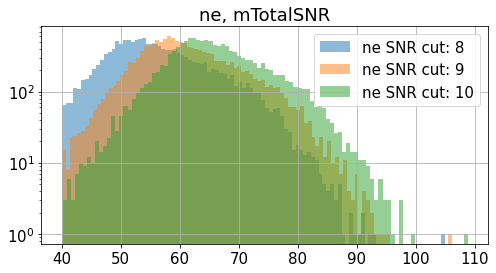

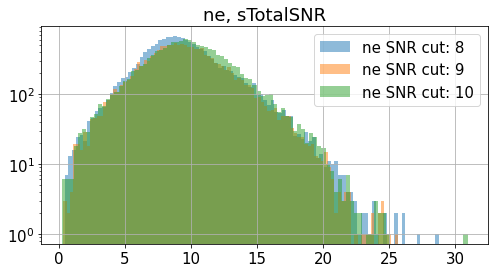

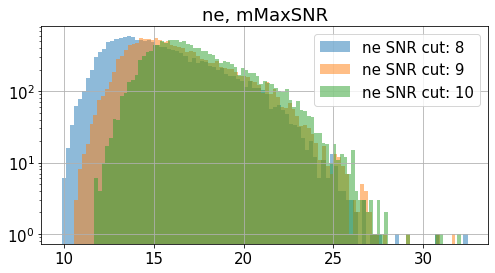

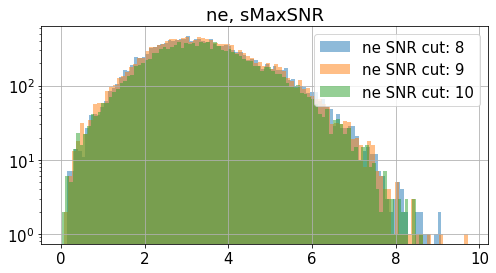

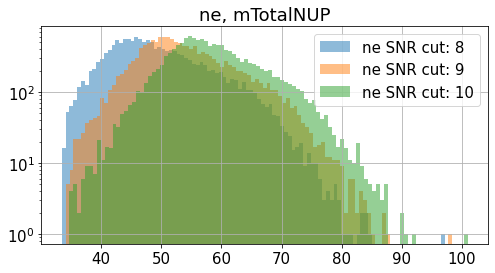

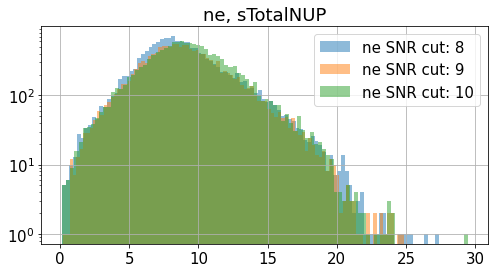

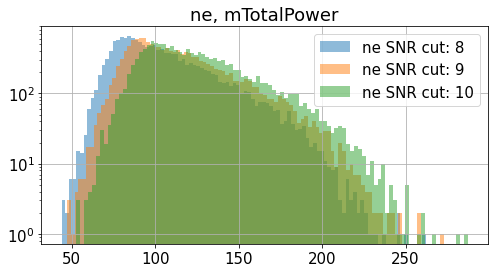

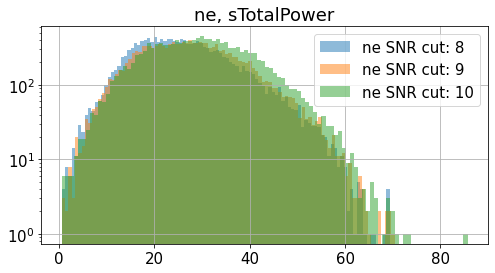

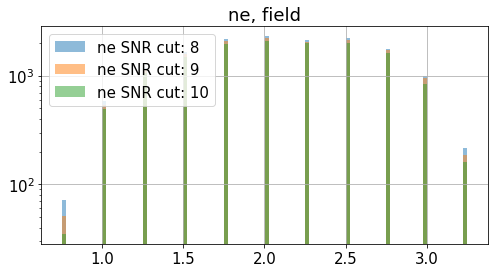

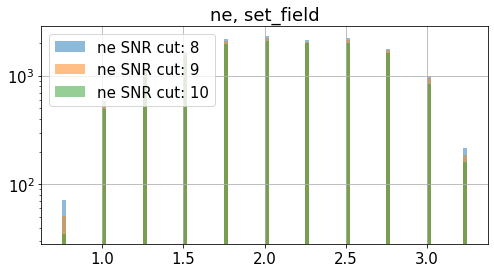

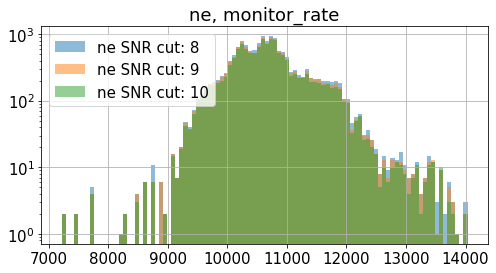

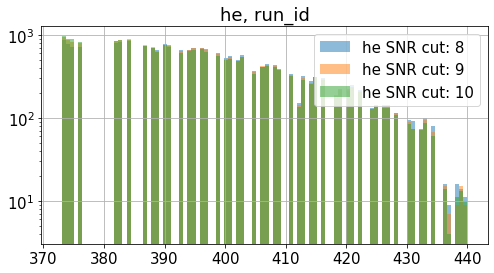

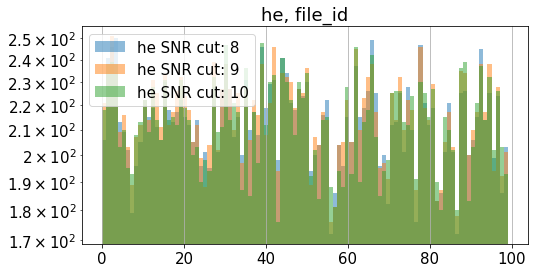

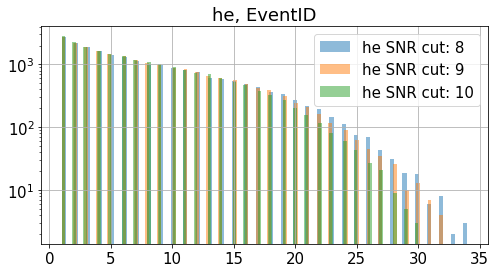

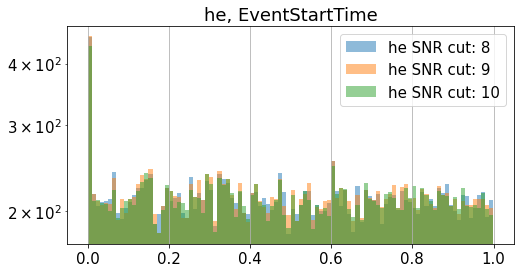

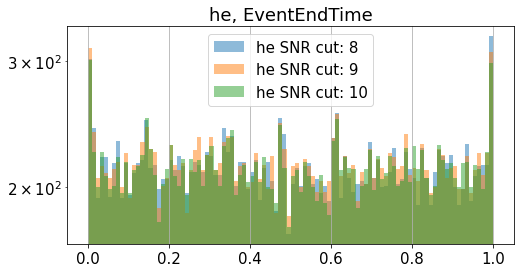

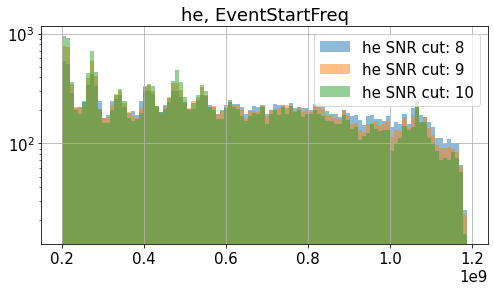

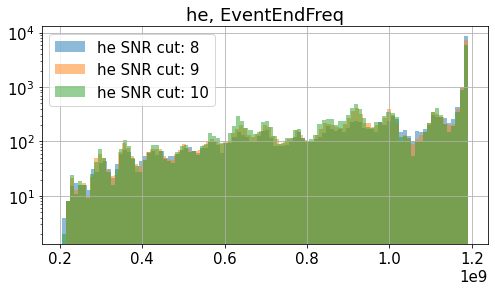

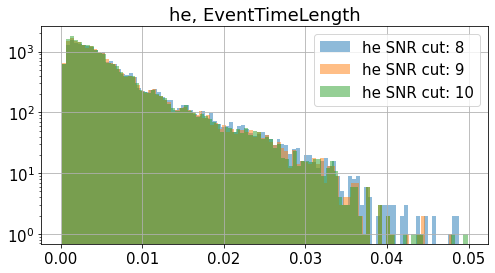

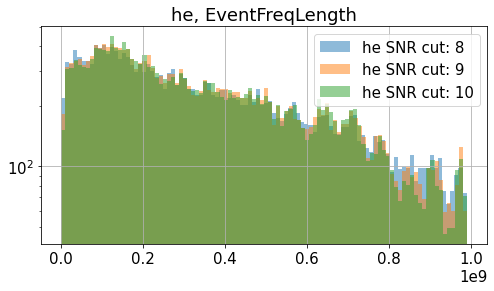

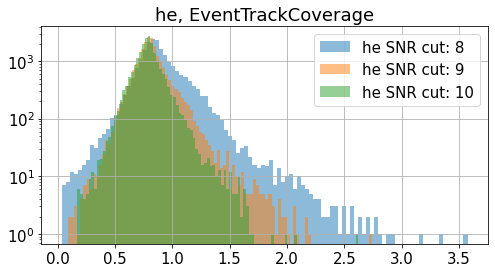

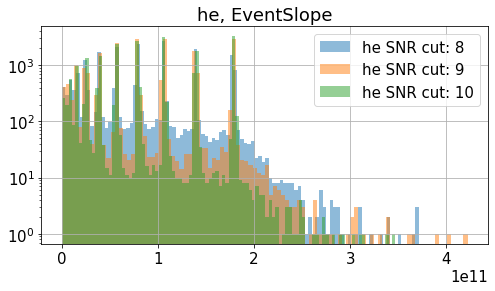

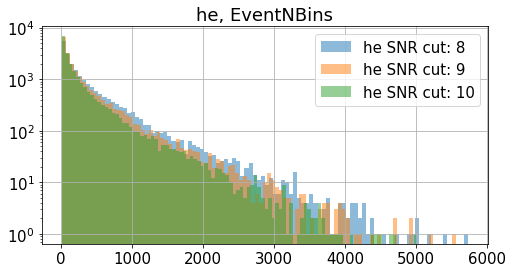

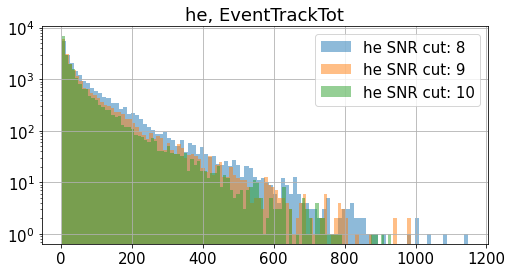

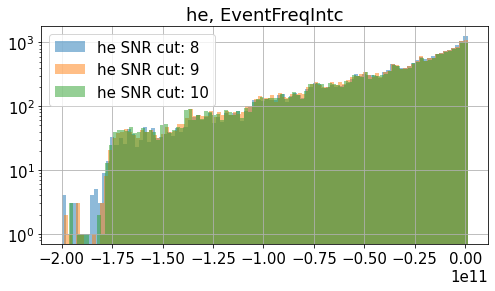

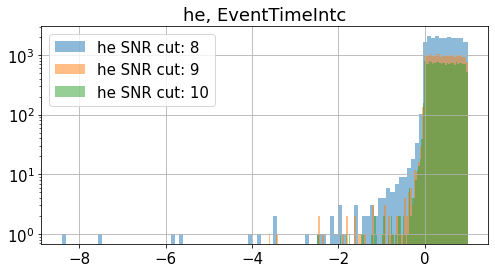

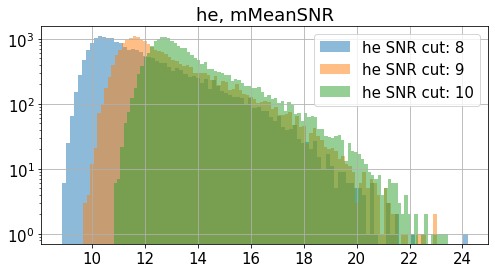

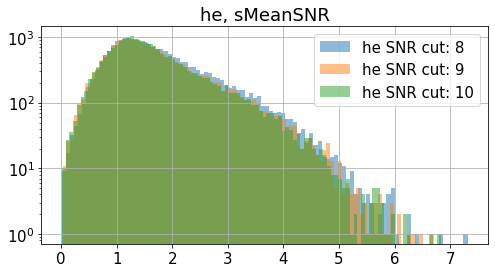

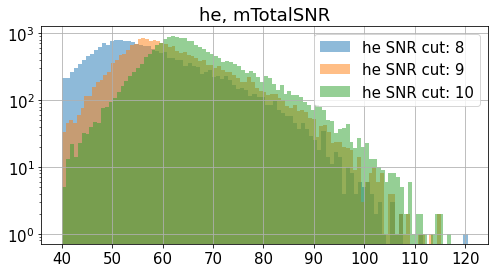

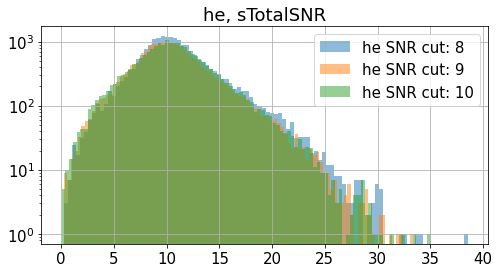

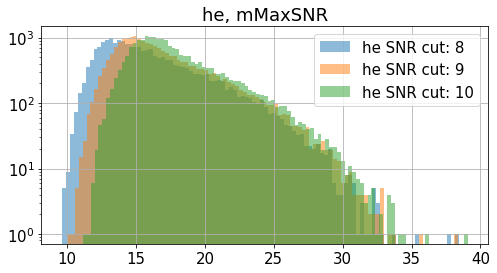

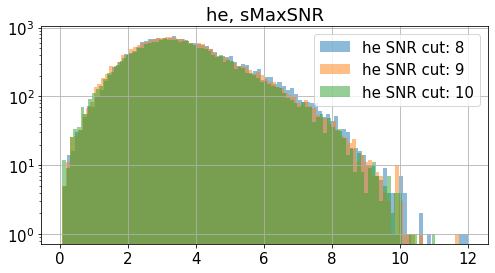

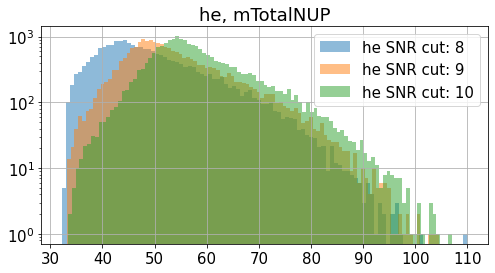

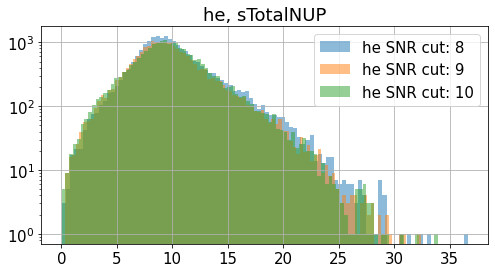

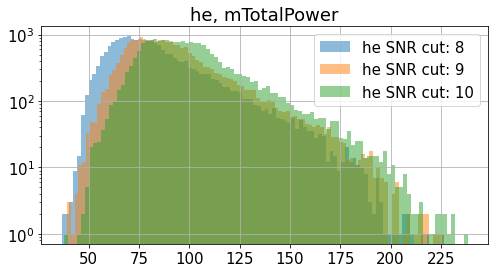

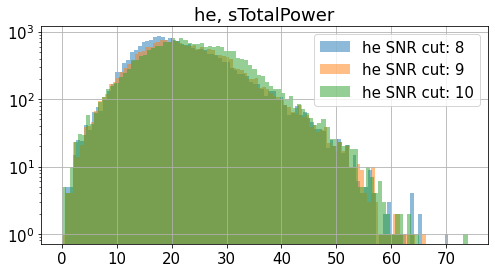

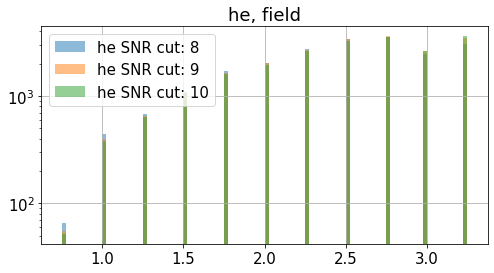

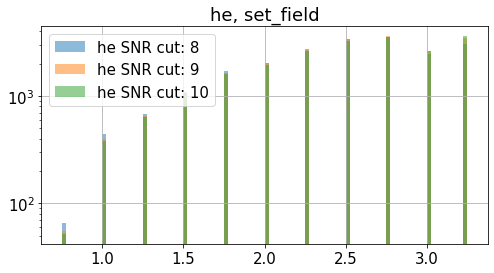

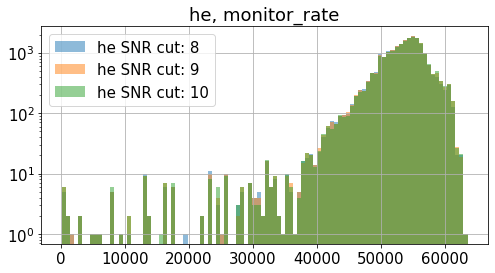

In [28]:
%matplotlib inline
# %matplotlib widget
plt.rcParams.update({'font.size': 15})

for isotope in snr_study.keys(): 
    
    for column in snr_study[isotope][cut].events.columns:

        fig, ax = plt.subplots(figsize=(8,4))
        for cut in snr_cuts: 
            
            events = snr_study[isotope][cut].events

            if isotope == "ne": 
                events_cut = re.cut_df(events, ne_cuts)
            
            if isotope == "he": 
                events_cut = re.cut_df(events, he_cuts)
      
            # Go through each field and make sure things look ok. 
            condition = (events_cut.set_field != 100)
         
            events_cut = events_cut[condition]

            density = False

            events_cut.hist(column = column, bins = 100, density = density,  alpha = .5, ax = ax, label = f"{isotope} SNR cut: {cut}")

        plt.title(f"{isotope}, {column}")
        ax.set_yscale("log")
        plt.legend()

        plt.show()

### QC Test 2: Look at the 10,50,90 quartiles of all feature distributions. 

Notes: Keep an eye out for outliers.

In [32]:
# 10th Percentile
def q10(x):
    return x.quantile(0.1)

# 50th Percentile
def q50(x):
    return x.quantile(0.5)

# 90th Percentile
def q90(x):
    return x.quantile(0.9)

In [33]:
both_cuts = {
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (.01, np.inf),
            "mTotalSNR": (40, np.inf),
            "mTotalNUP": (0, np.inf)
            }

additional_cuts = {
                "EventStartFreq": (400e6, 1200e6),
                "EventNBins": (0, np.inf),
                }
ne_cuts = {**both_cuts, **additional_cuts}
he_cuts = {**both_cuts, **additional_cuts}

cut = 9
events_ne = snr_study["ne"][cut].events
events_he = snr_study["he"][cut].events


events_ne = re.add_detectability(events_ne)
events_he = re.add_detectability(events_he)

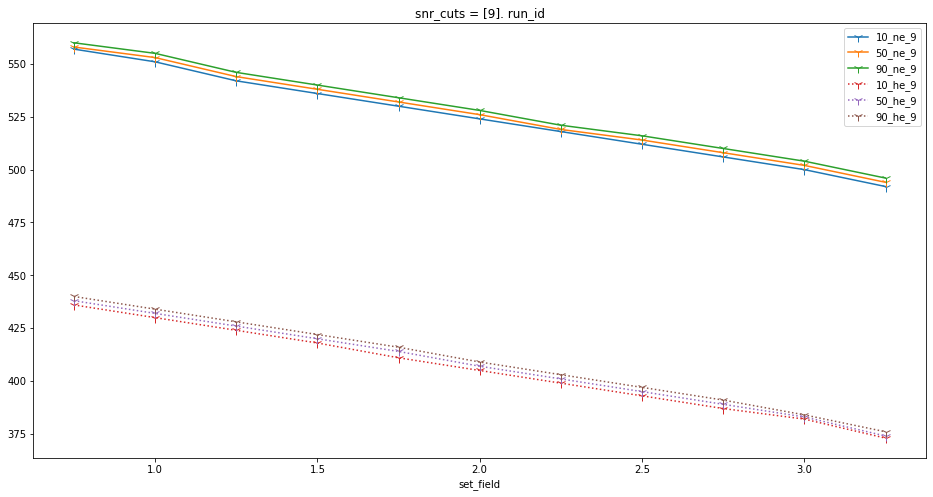

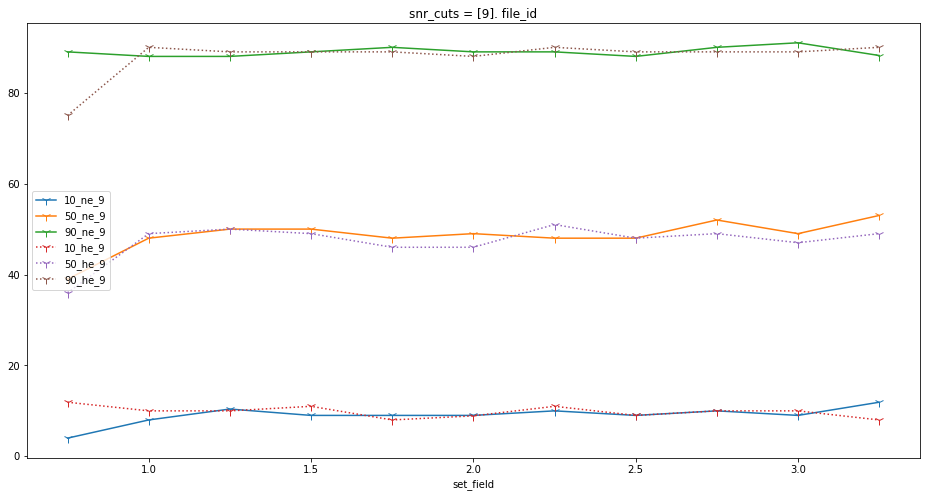

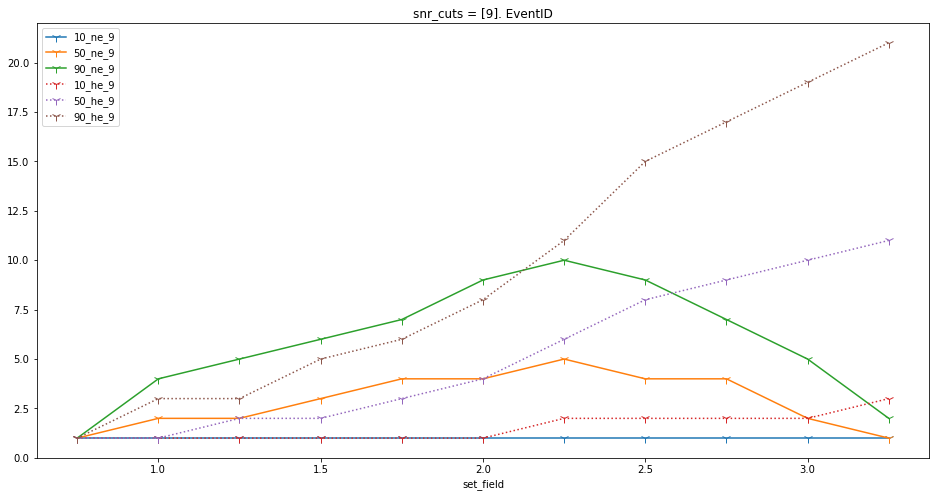

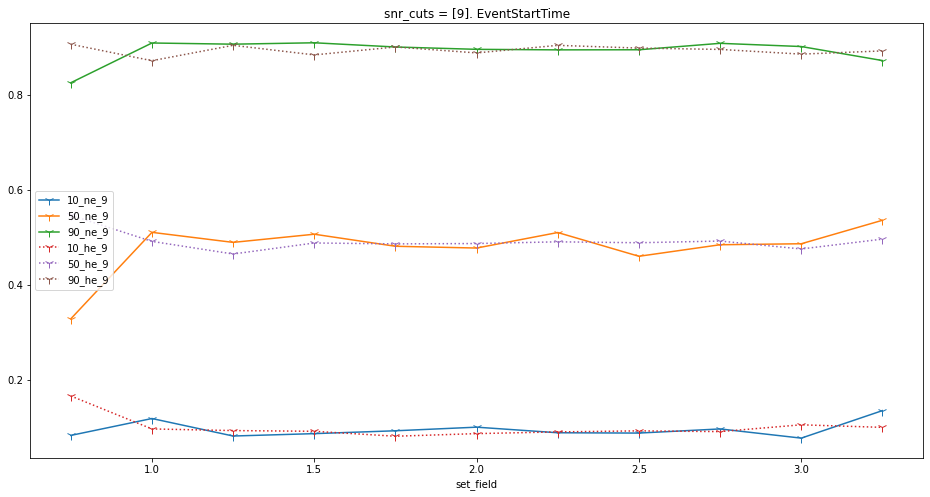

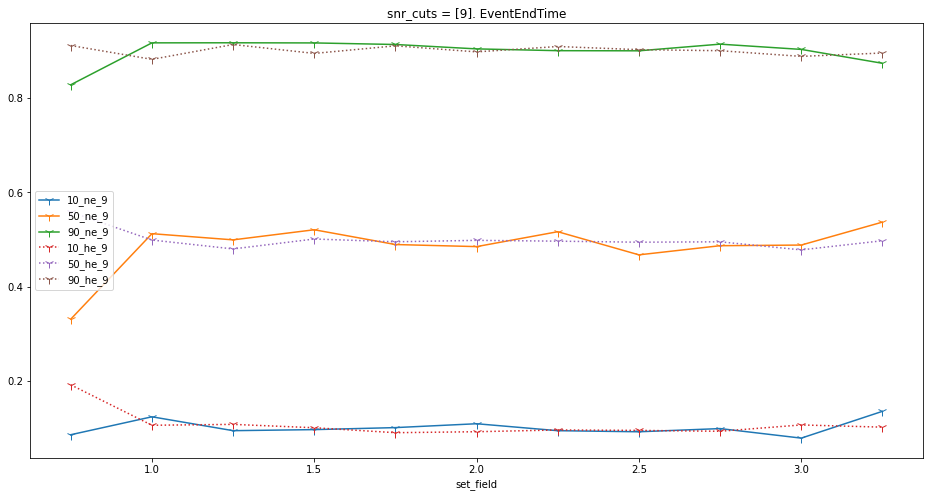

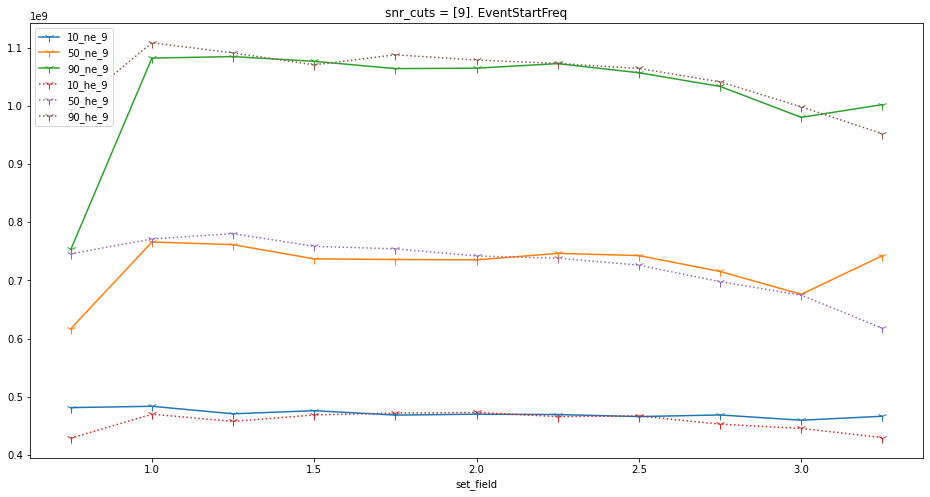

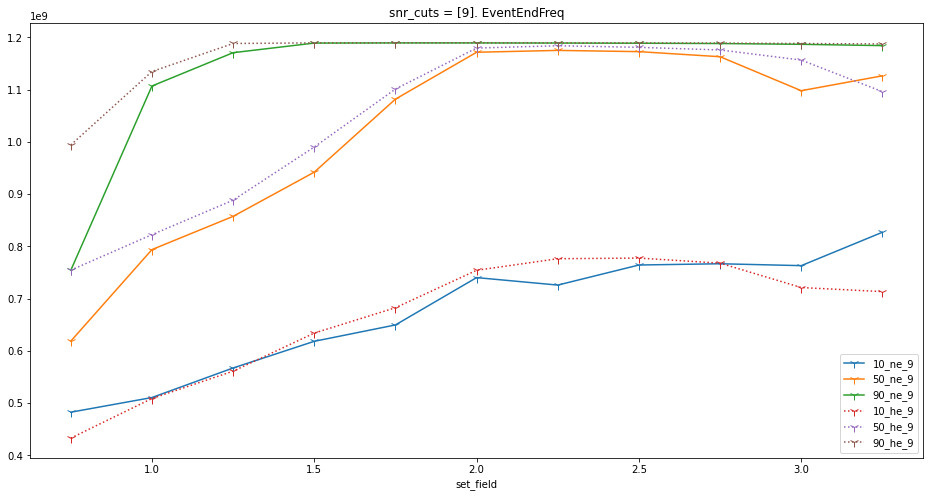

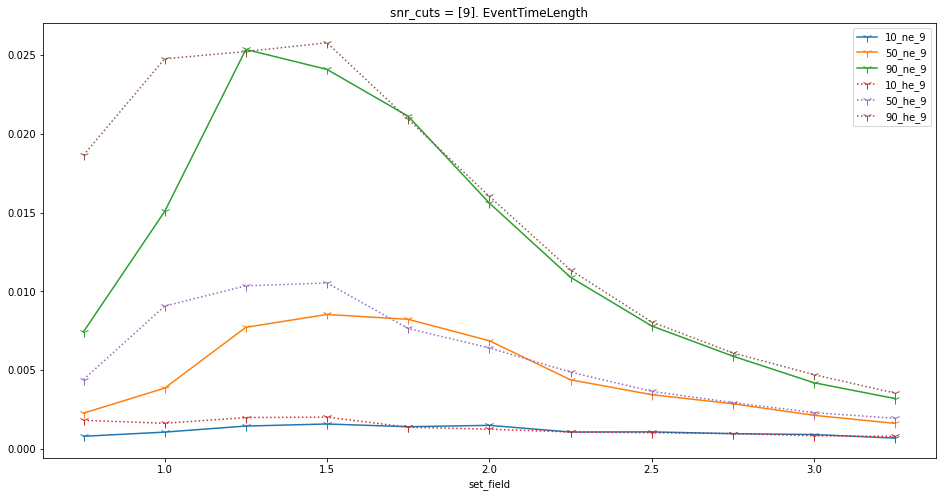

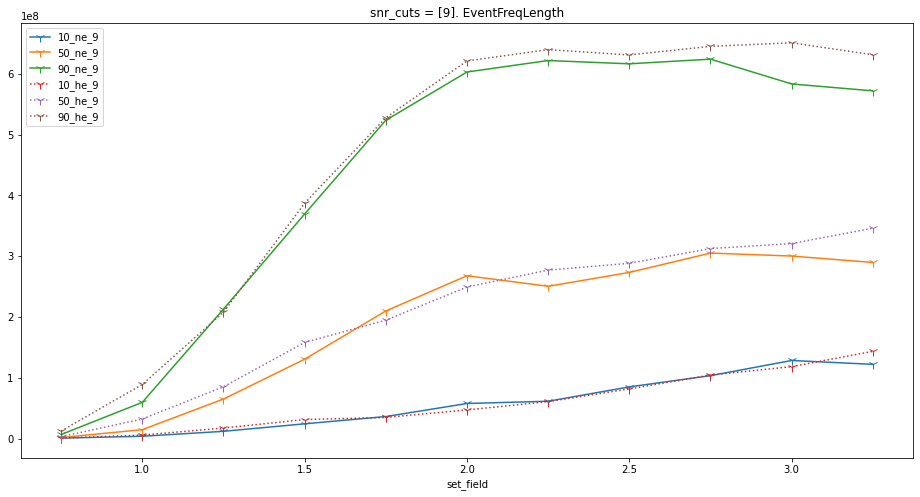

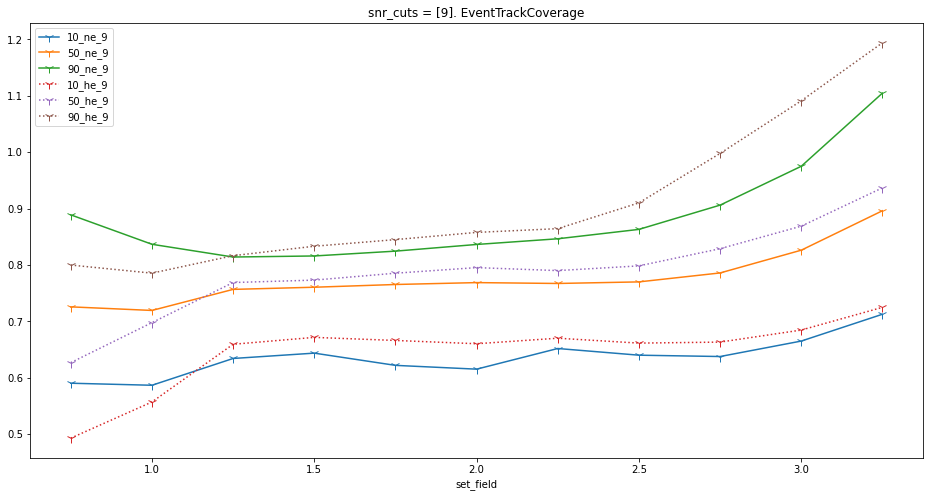

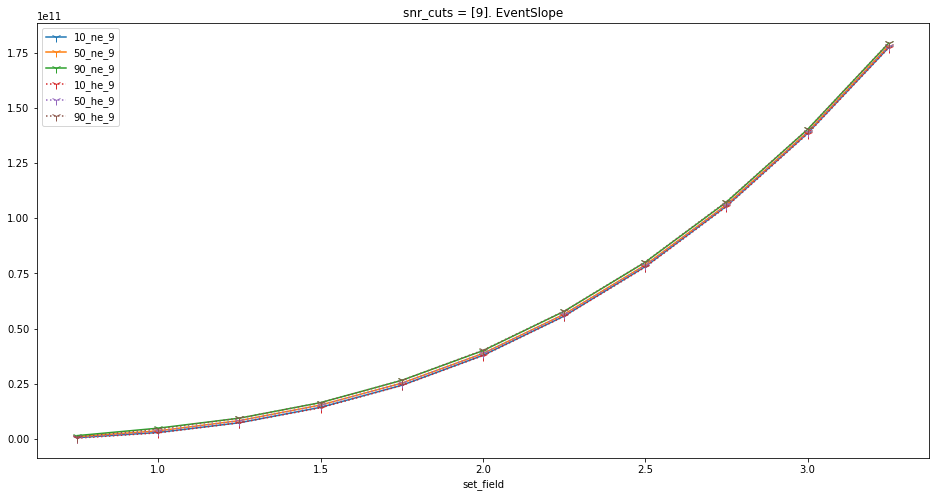

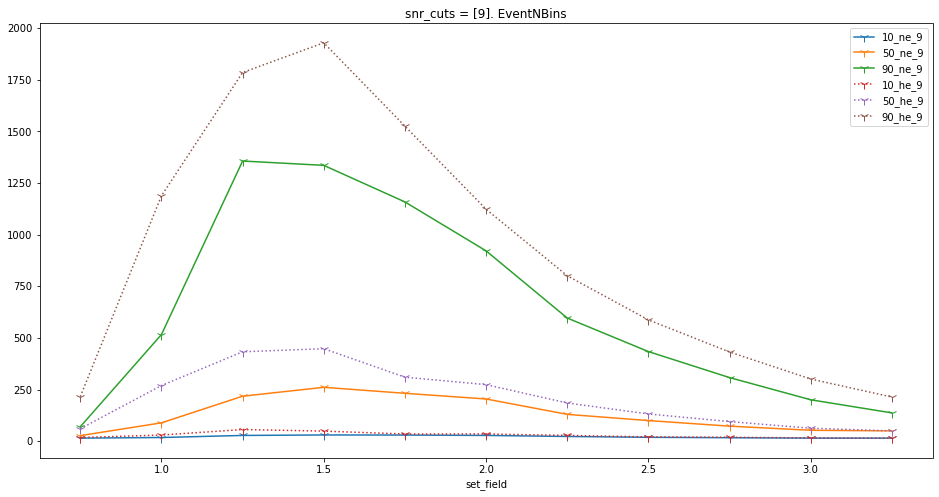

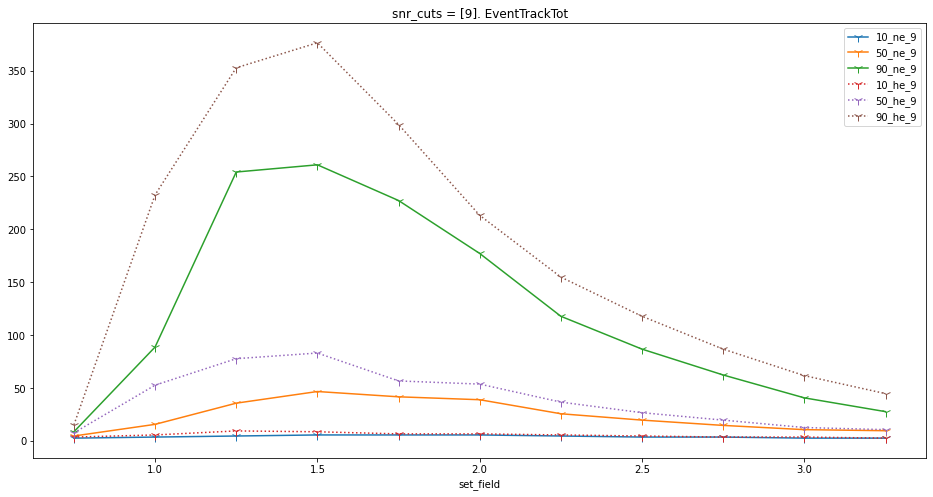

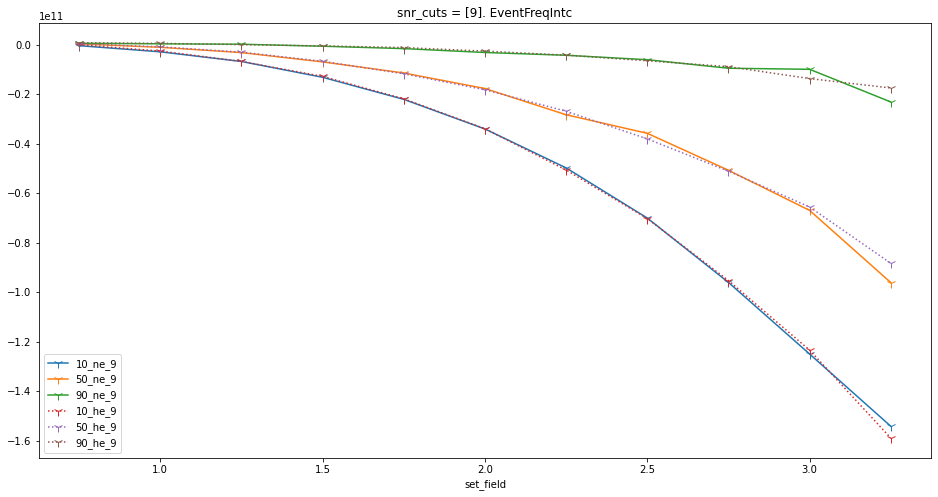

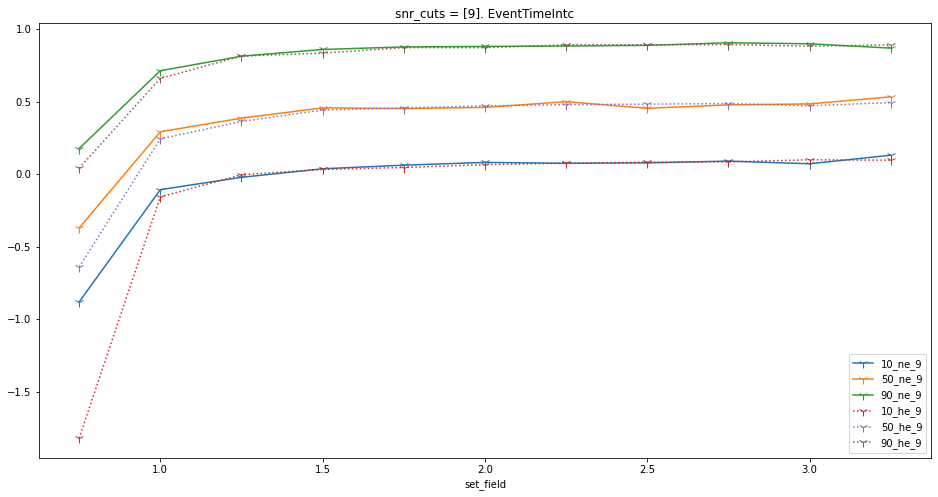

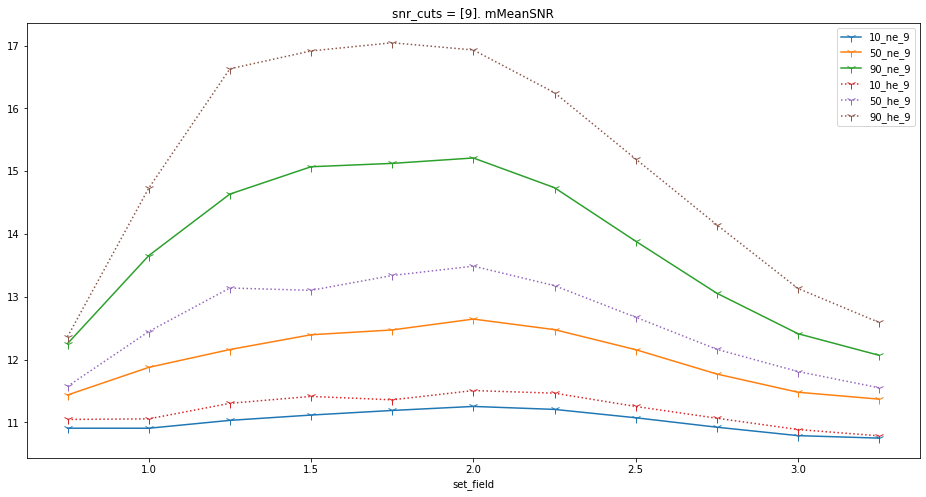

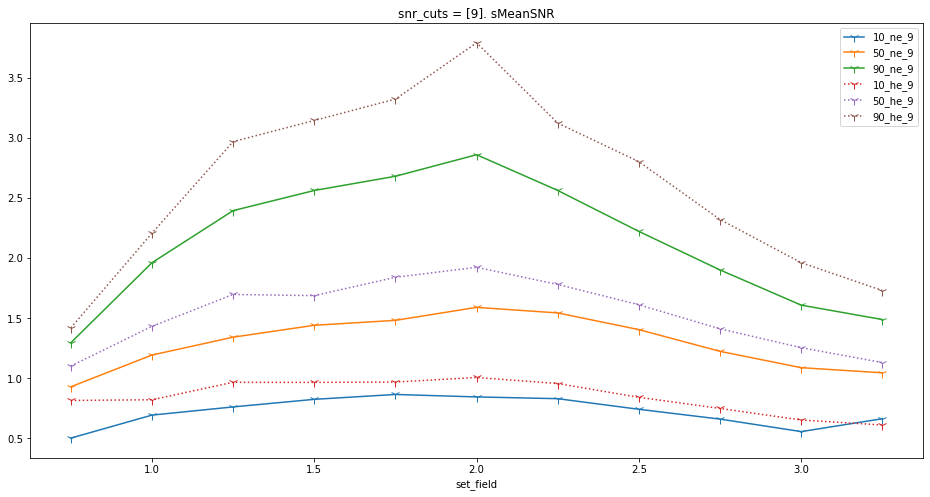

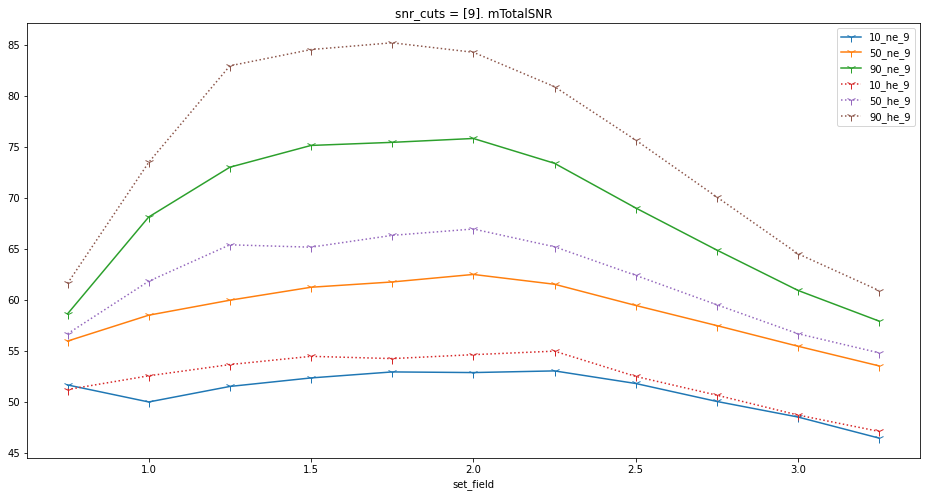

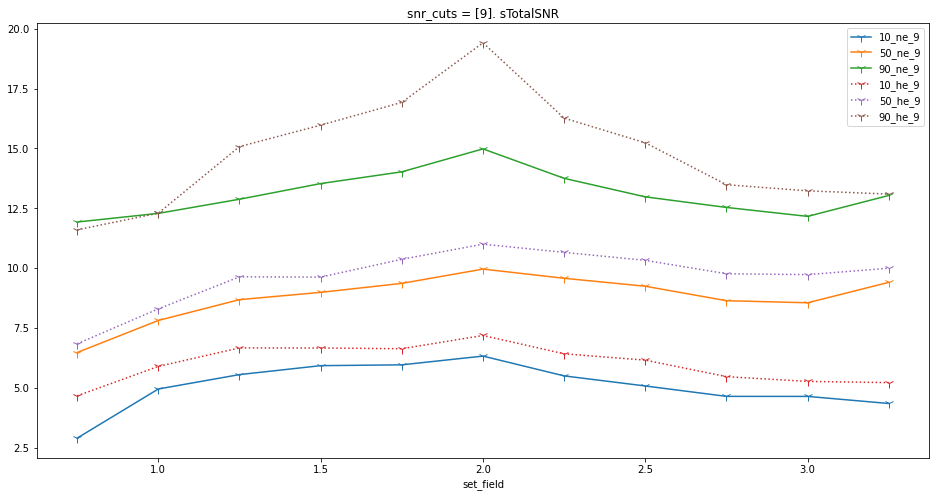

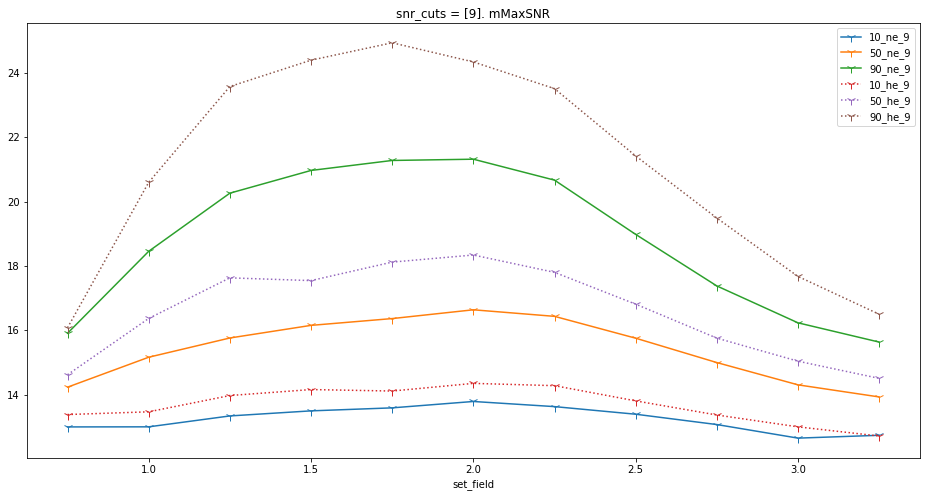

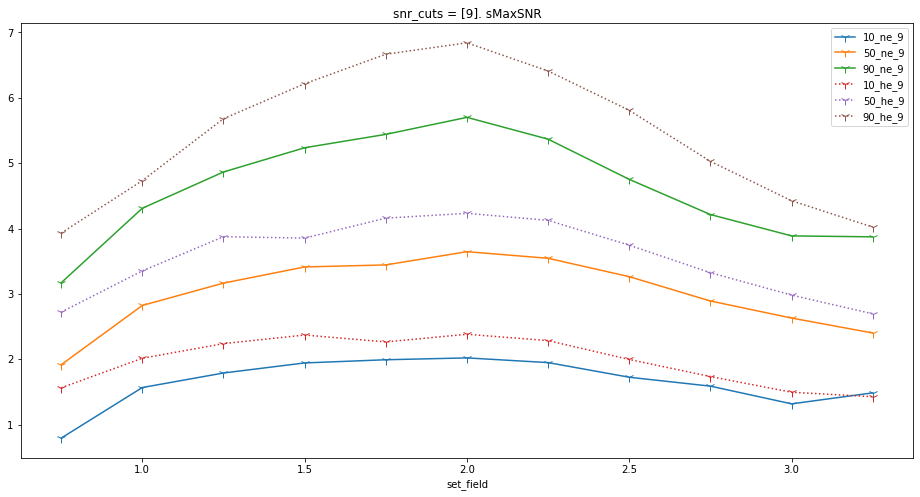

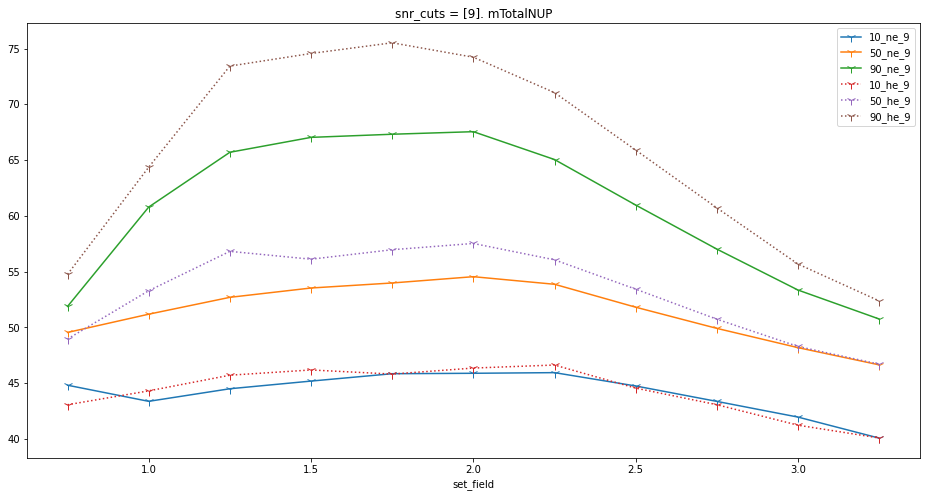

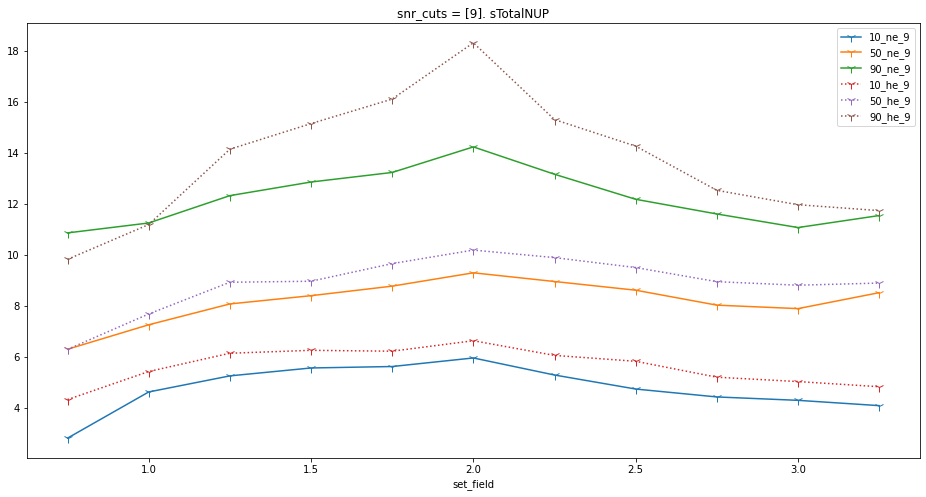

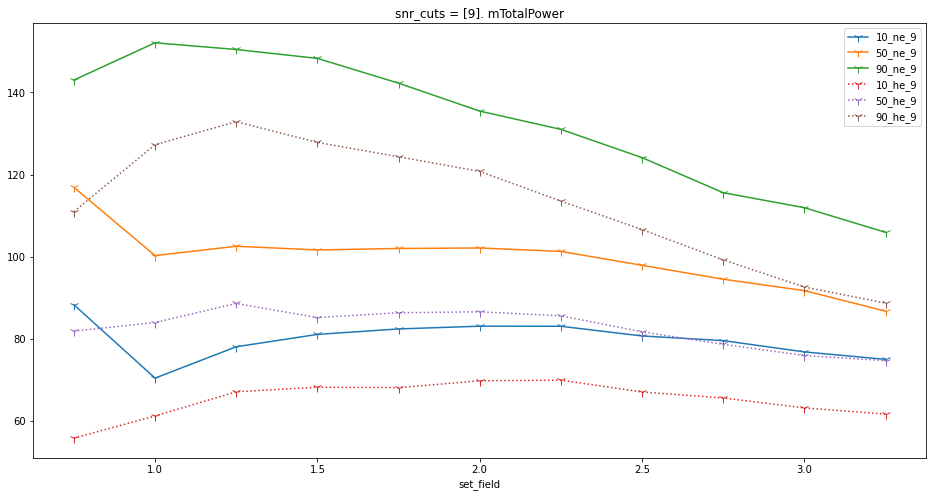

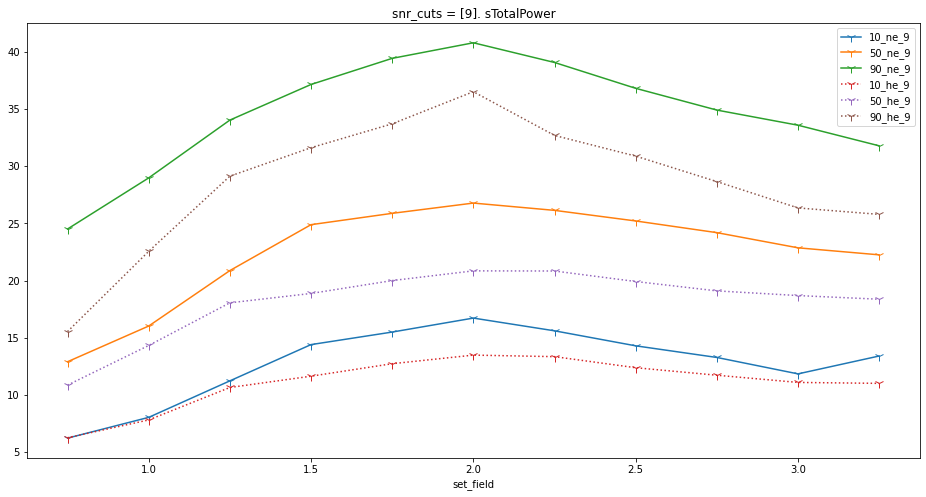

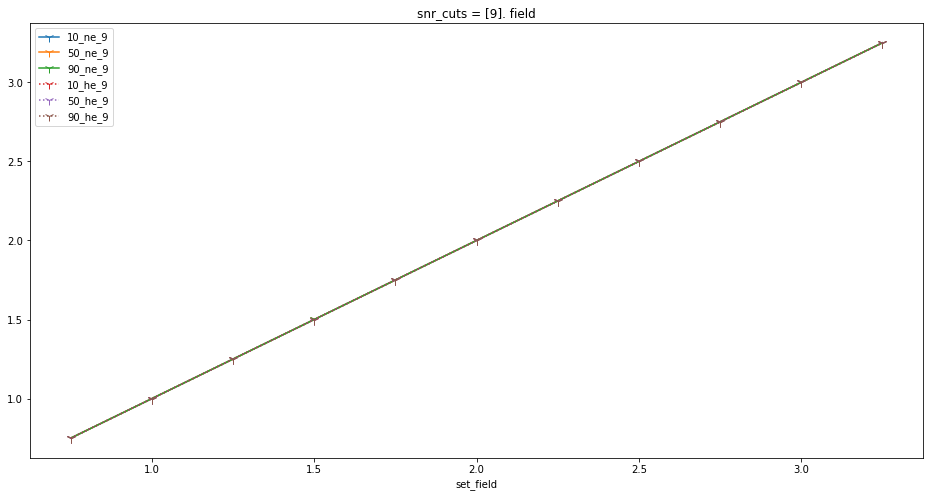

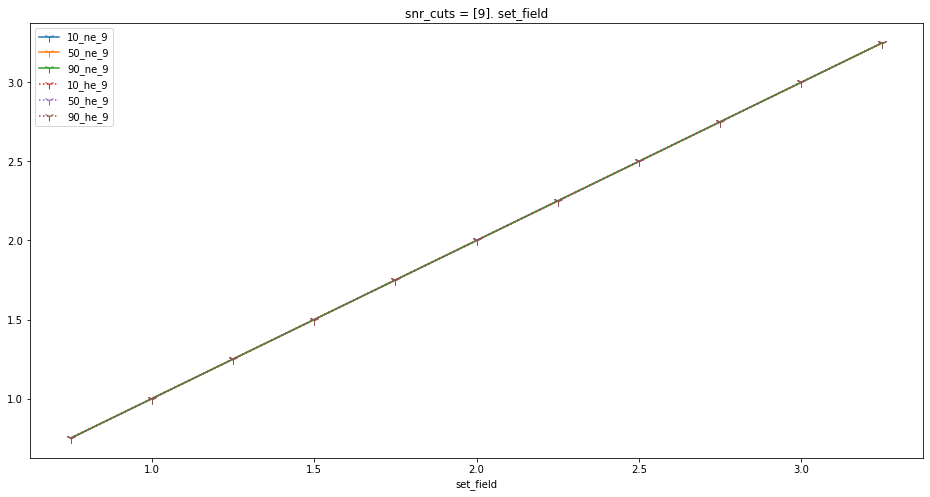

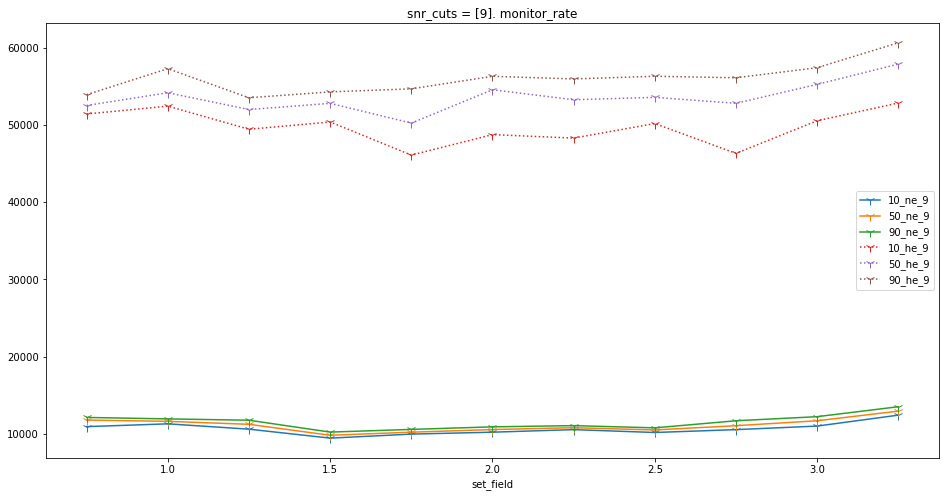

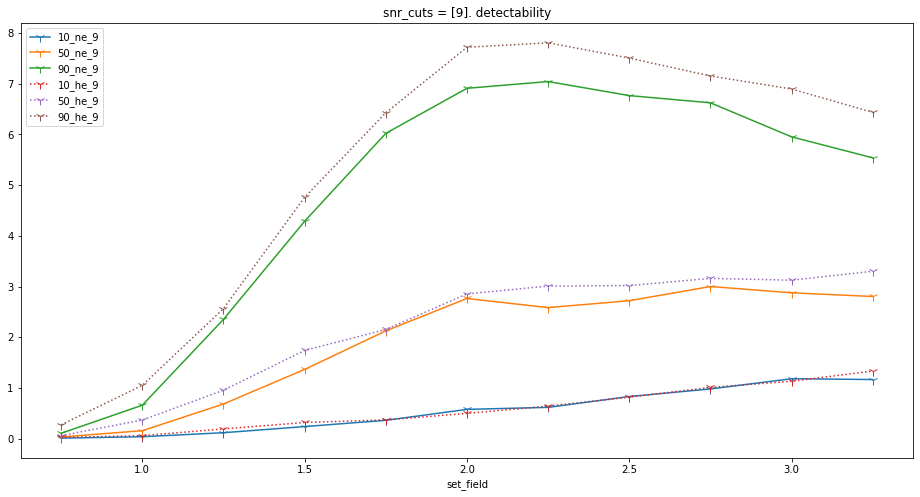

In [35]:
%matplotlib inline

aggs = [q10, q50, q90]
col_names = ["10", "50", "90"]

snr_cuts = [9]
for column in snr_study["ne"][9].events.columns: 
    
    fig0, ax0 = plt.subplots(figsize=(16,8))
    for i, cut in enumerate(snr_cuts):
        
        events_ne = snr_study["ne"][cut].events
        events_he = snr_study["he"][cut].events


        events_ne = re.add_detectability(events_ne)
        events_he = re.add_detectability(events_he)
        
        # print(events_ne.EventStartFreq.min())
        events_cut_ne = re.cut_df(events_ne, ne_cuts)
        events_cut_he = re.cut_df(events_he, he_cuts)
        # print(events_cut_ne.EventStartFreq.min())
        ne_col_names = [col_name + f"_ne_{cut}" for col_name in col_names]
        he_col_names = [col_name + f"_he_{cut}" for col_name in col_names]
        orig_col_names = ["q" + col_name for col_name in col_names]

        events_cut_ne.groupby("set_field")[column].agg(aggs).rename(columns = dict(zip(orig_col_names, ne_col_names))).plot(ax = ax0, marker =f"{i+1}", ms = 10 )
        events_cut_he.groupby("set_field")[column].agg(aggs).rename(columns = dict(zip(orig_col_names, he_col_names))).plot(ax = ax0, ls = "dotted",marker =f"{i+1}", ms = 10)
    plt.title(f"snr_cuts = {snr_cuts}. {column}")
    plt.legend()
    plt.show()
    

### QC Test 3: Visualize Events to gaurentee things look sensible. 

* Notes: 
    * I don't see anything too weird. Lots coming from below for he... 

In [49]:
both_cuts = {
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (.01, np.inf),
            "mTotalSNR": (40, np.inf),
            "mTotalNUP": (0, np.inf)
            }

additional_cuts = {
                "EventStartFreq": (0e6, 1200e6),
                "EventNBins": (0, np.inf),
                }
ne_cuts = {**both_cuts, **additional_cuts}
he_cuts = {**both_cuts, **additional_cuts}




NEON


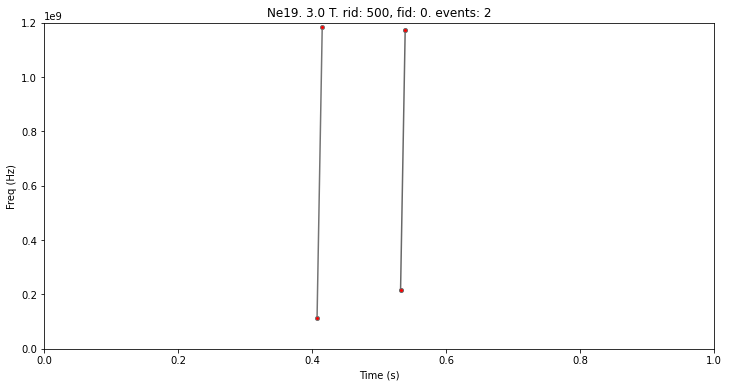

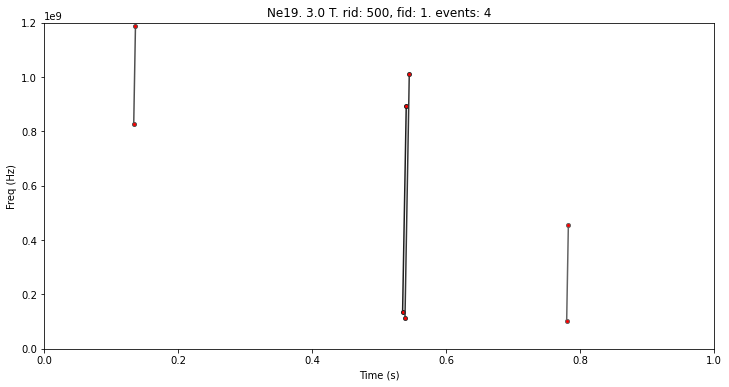

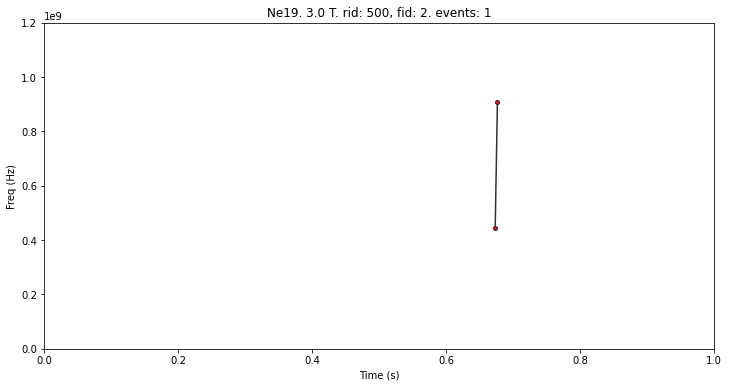

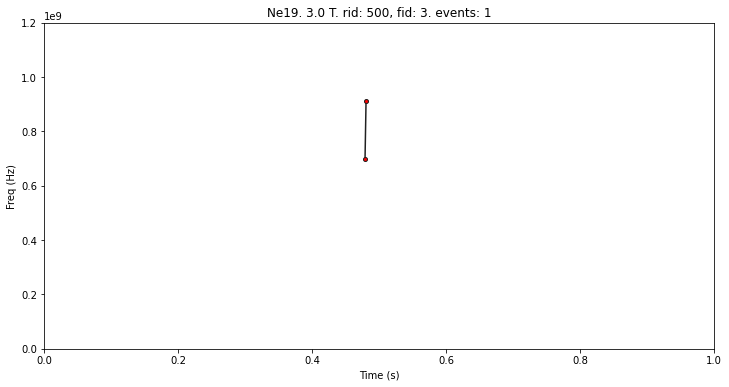

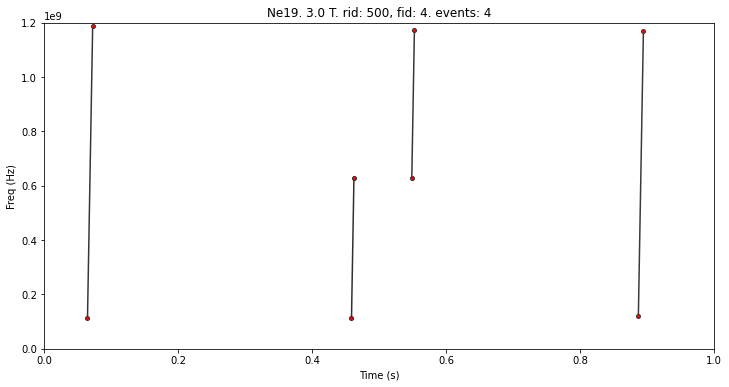

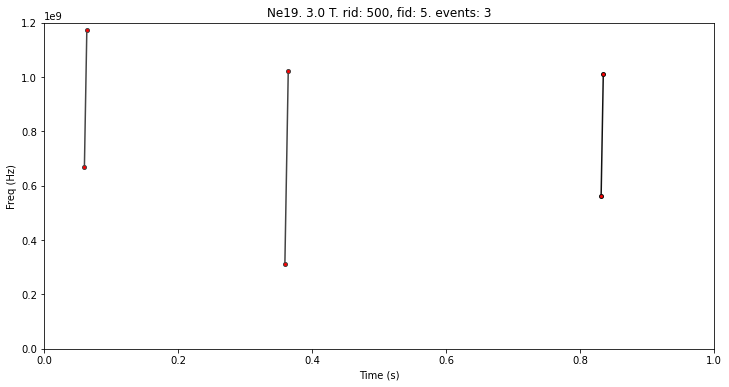

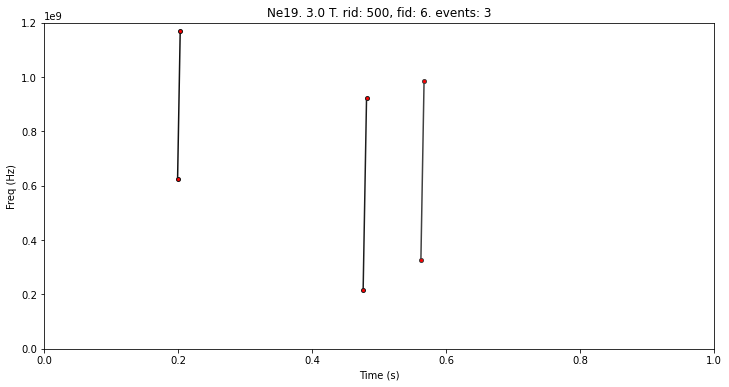

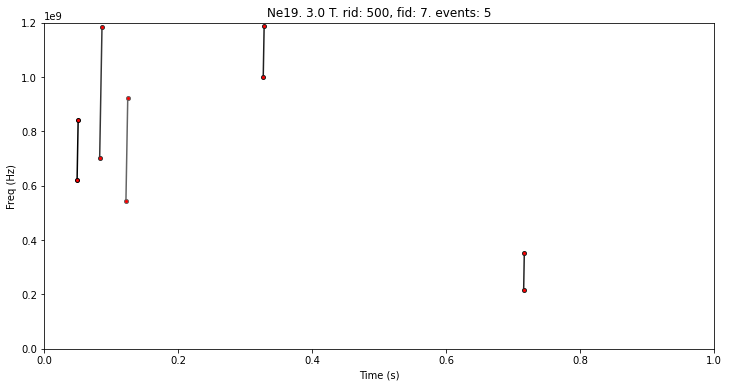

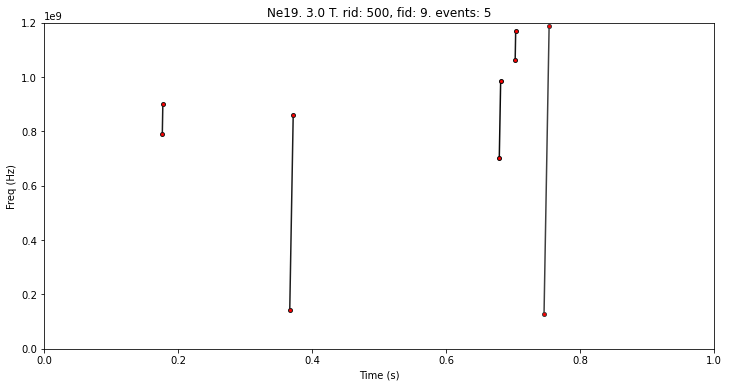

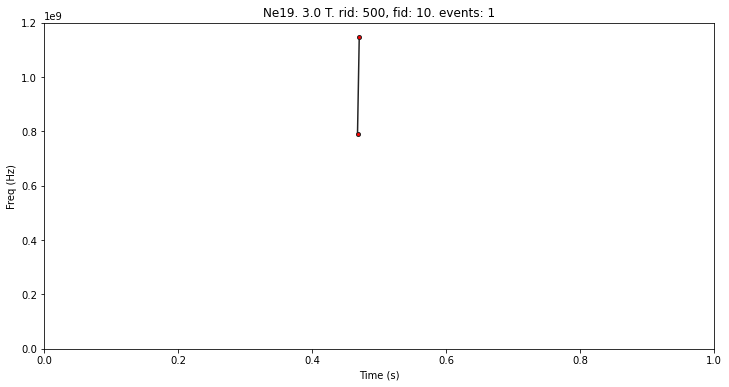

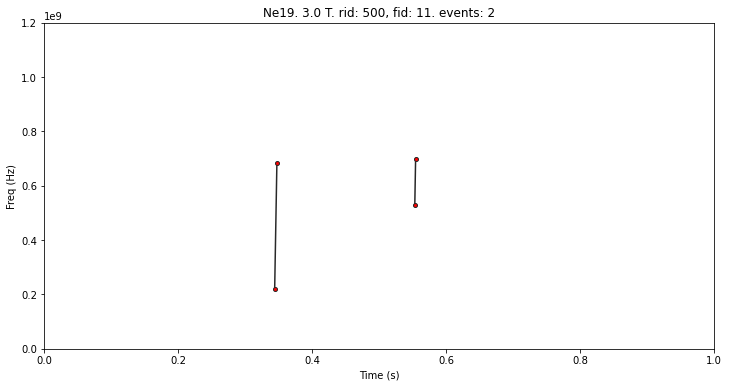

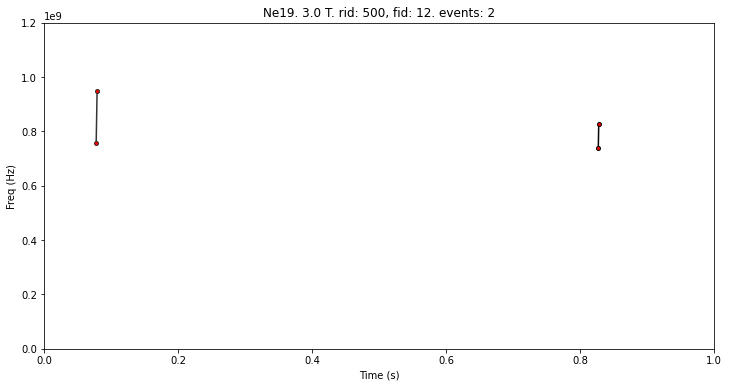

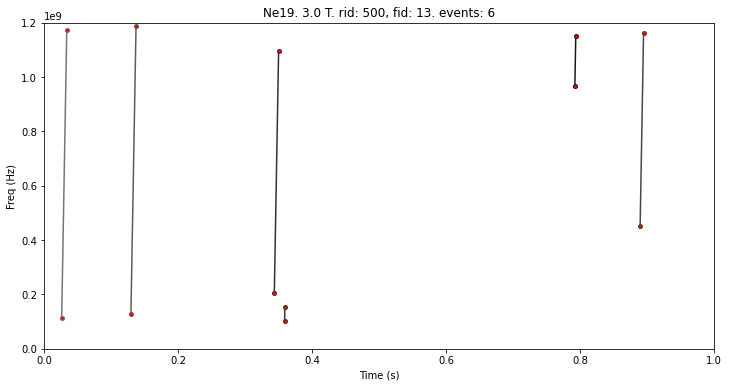

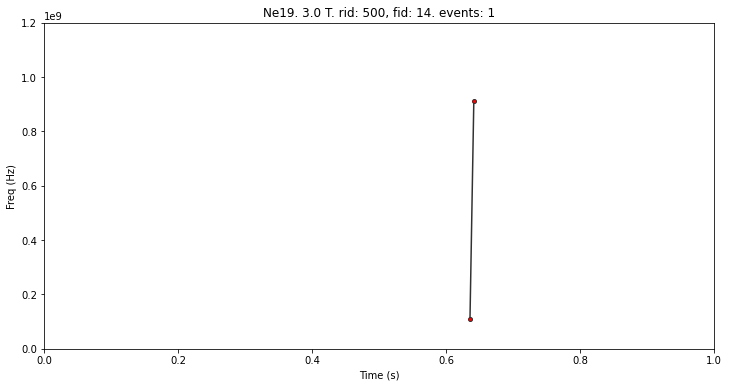

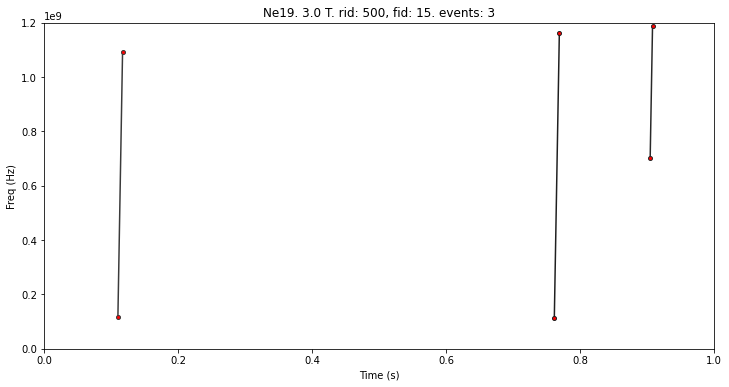

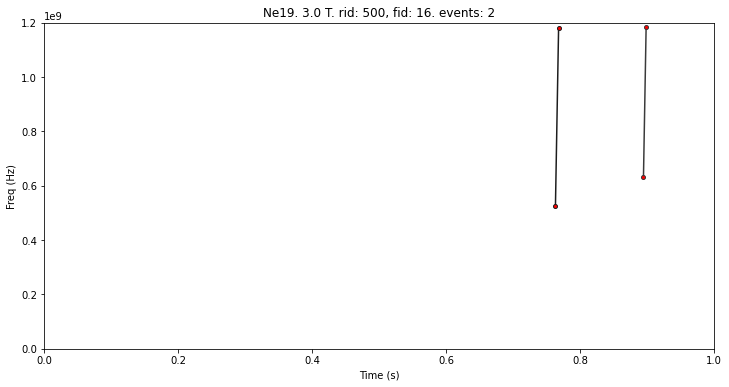

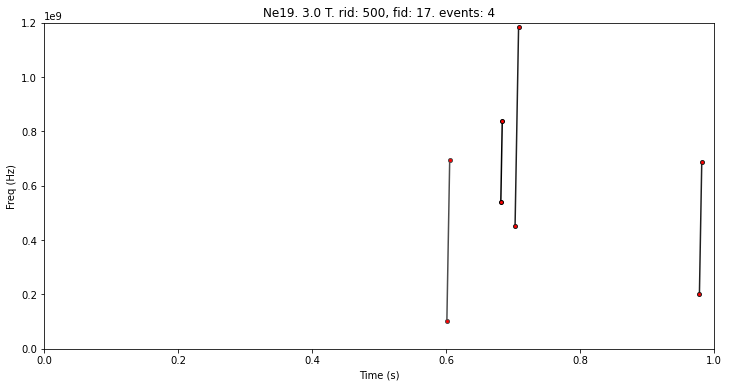

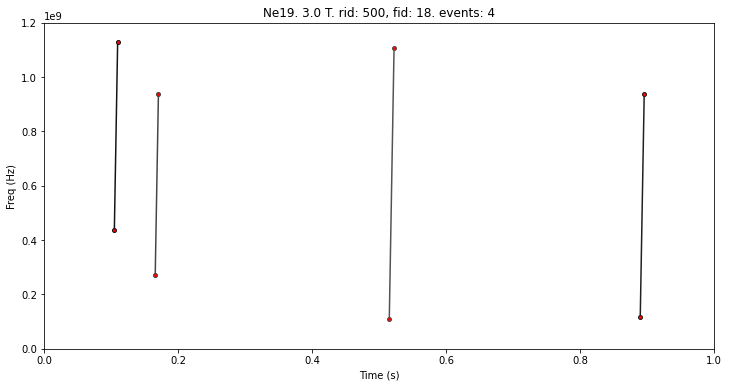

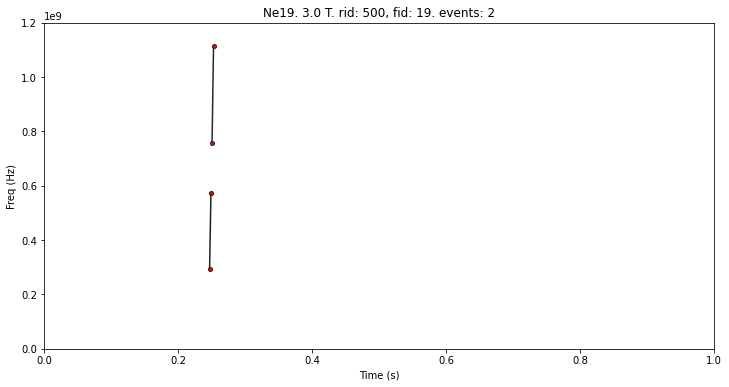

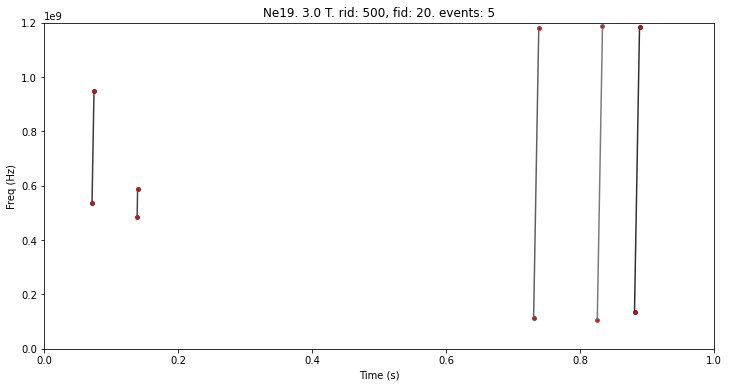

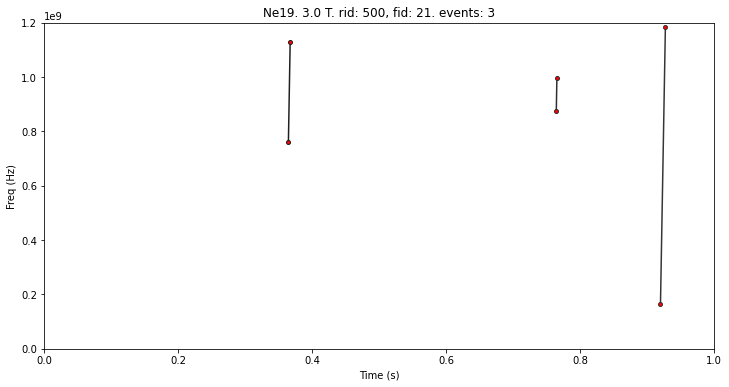

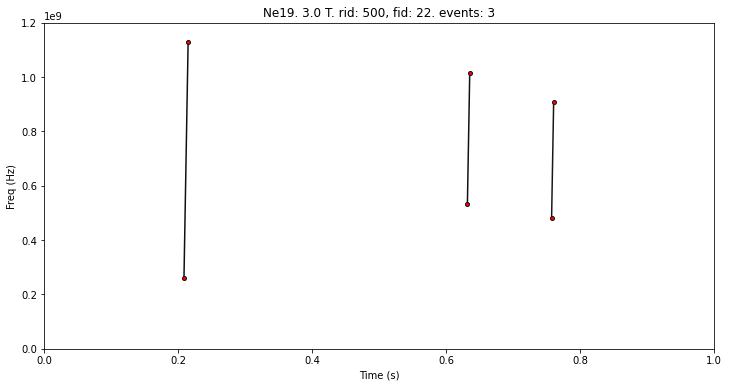

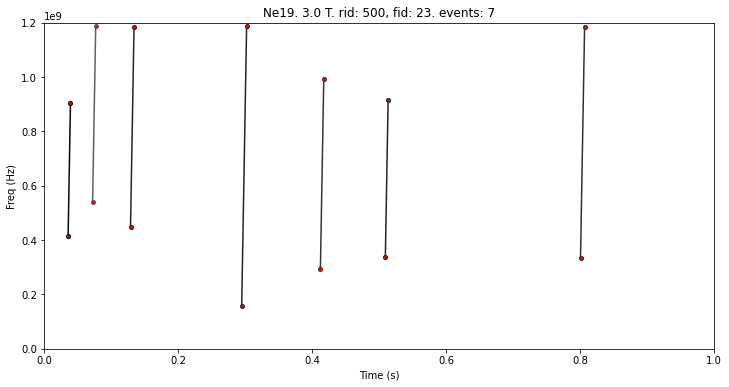

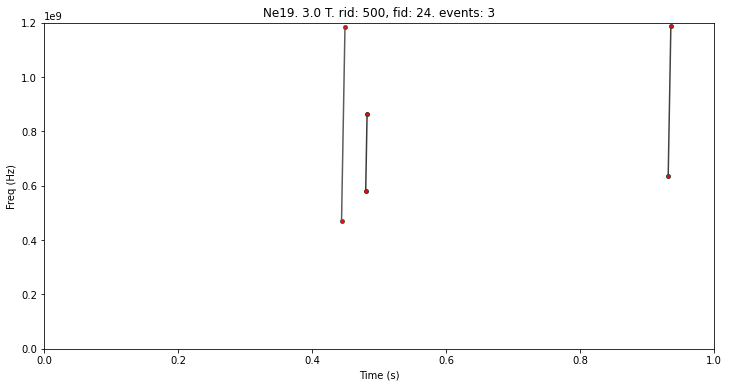

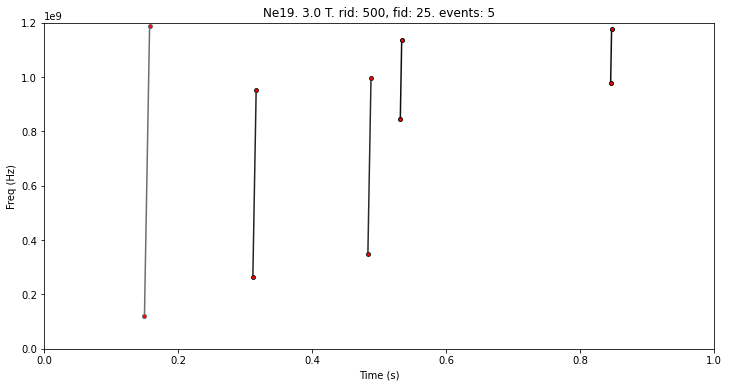

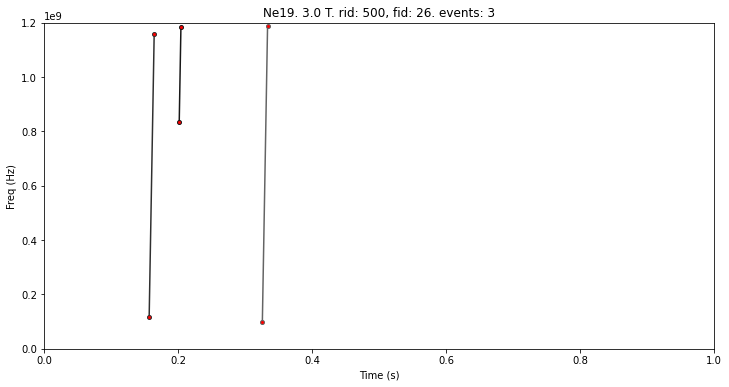

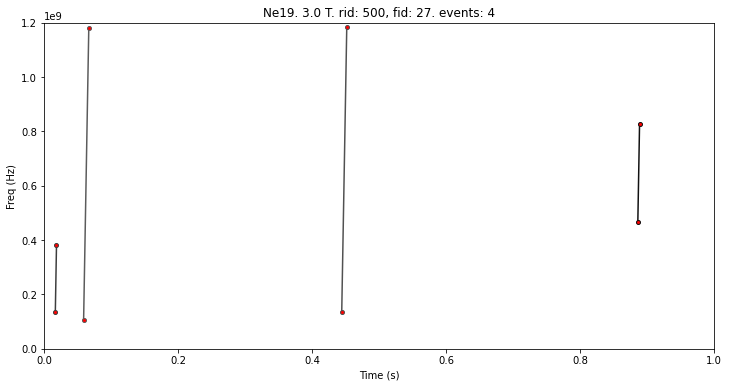

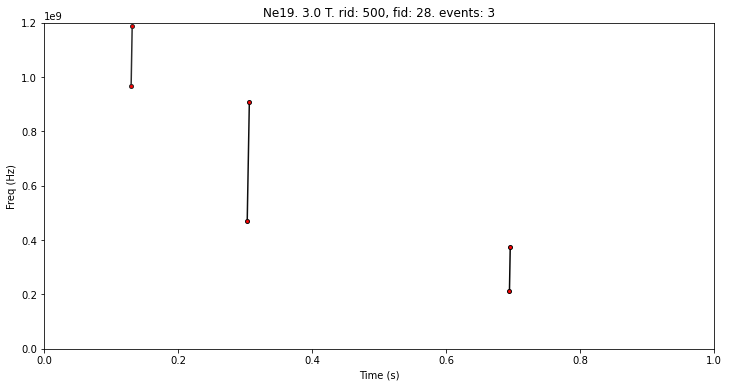

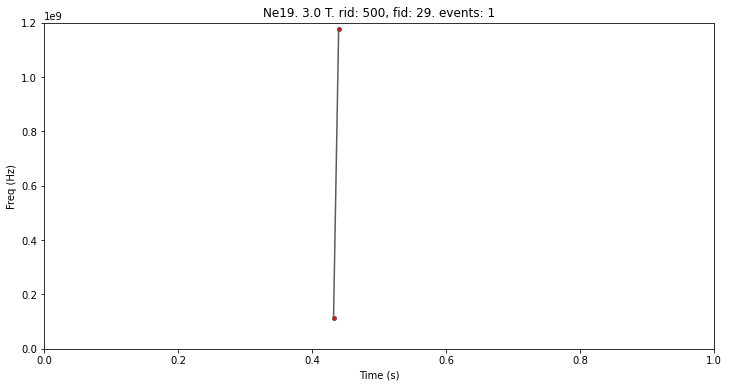

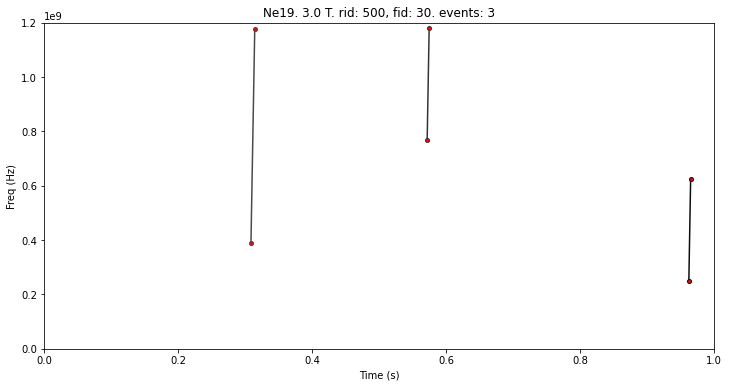

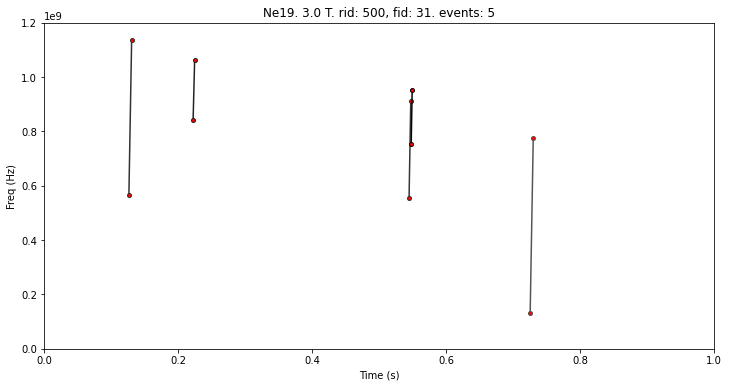

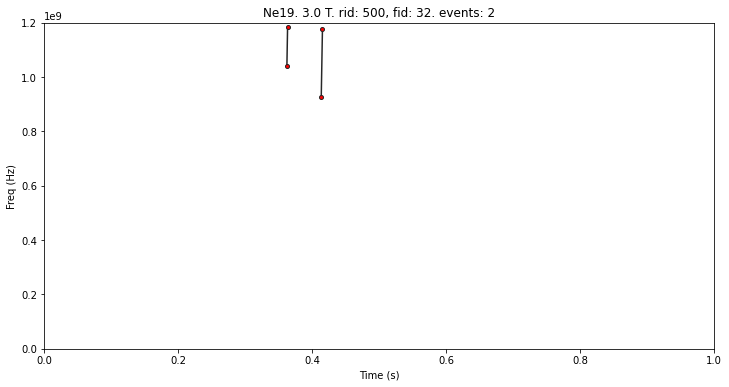

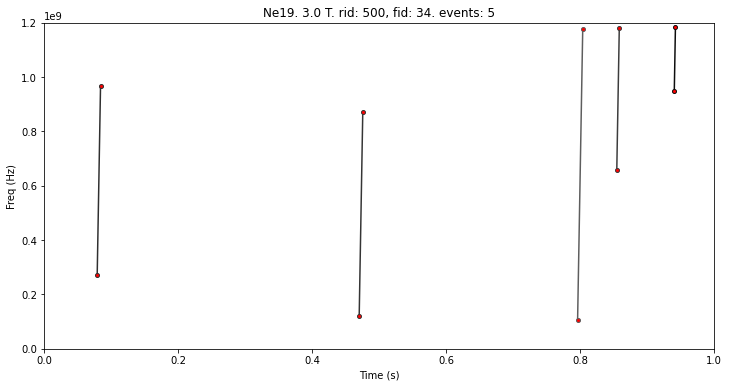

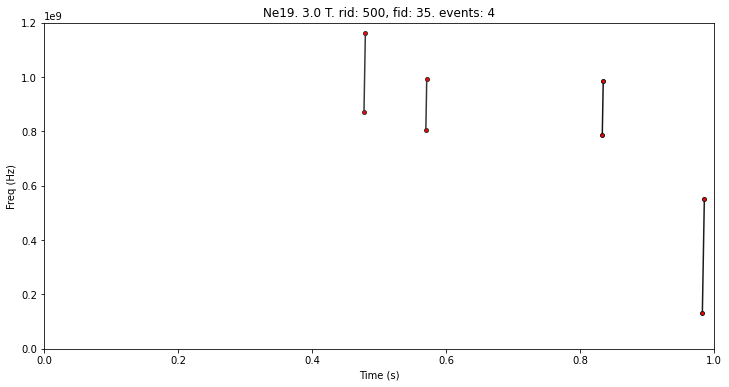

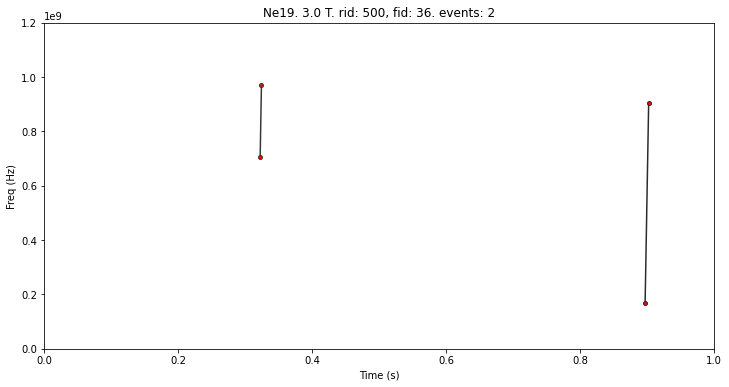

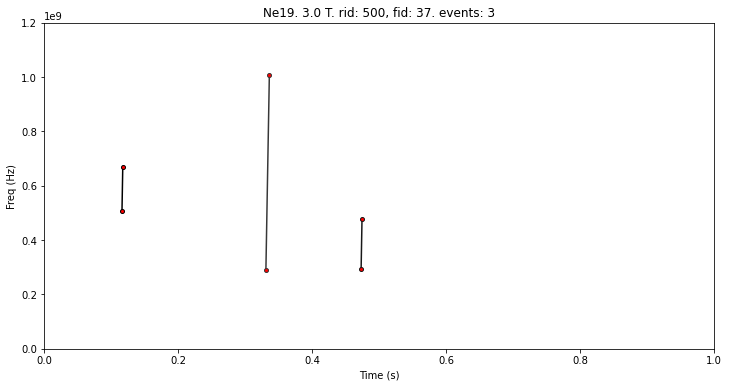

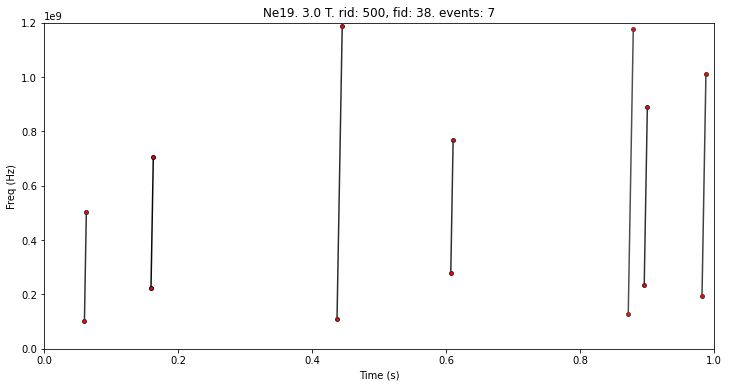

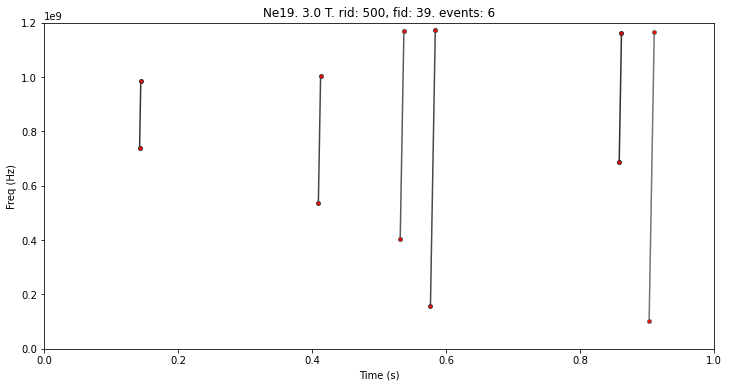

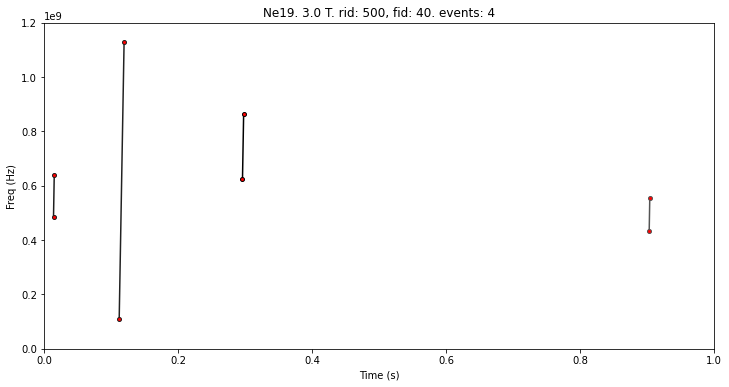

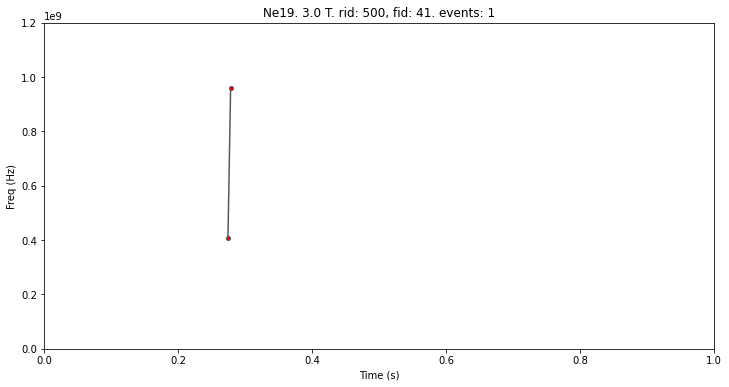

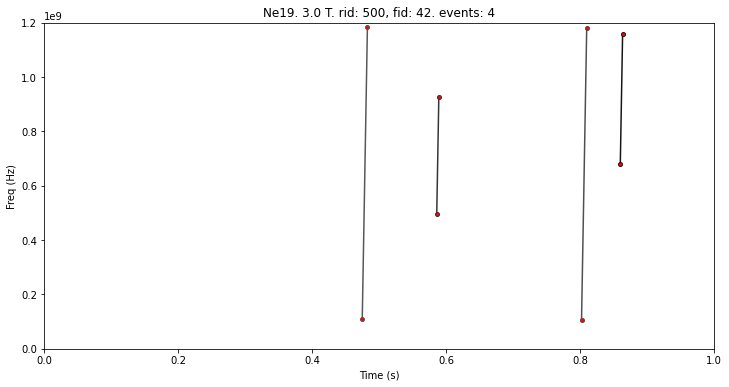

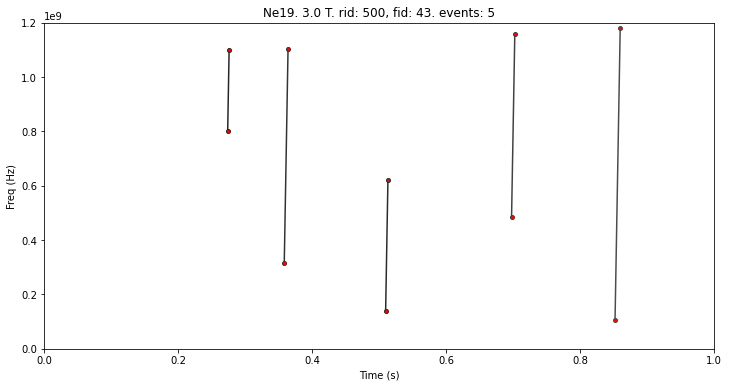

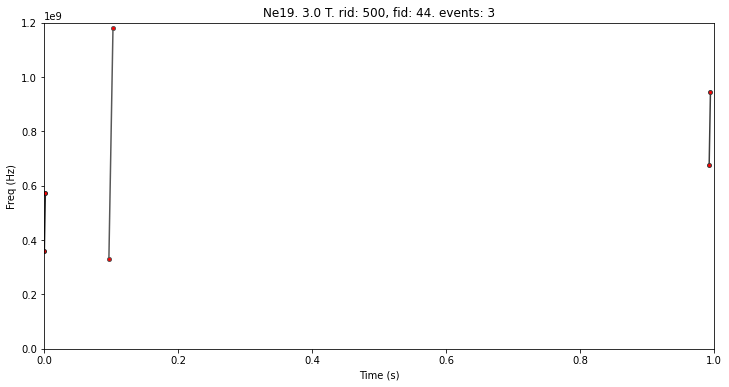

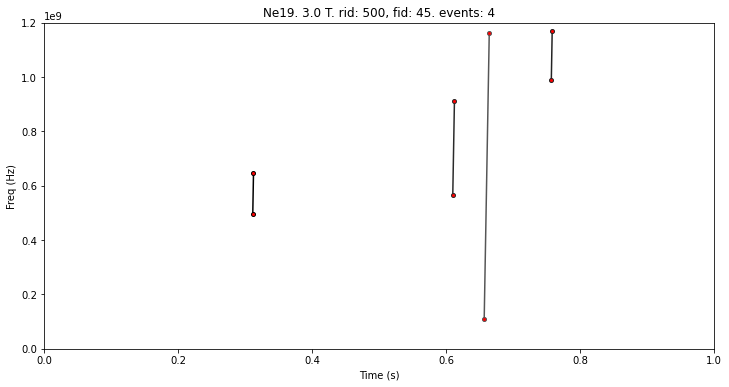

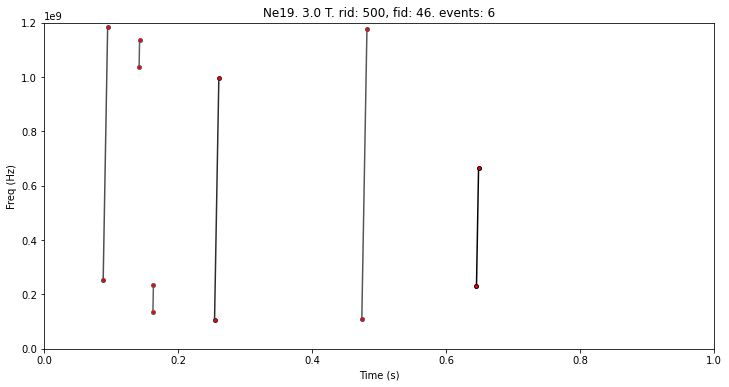

KeyboardInterrupt: 

<Figure size 864x432 with 0 Axes>

In [50]:
cut = 9
set_fields = [3.0]
fid_max = 50

events_ne = snr_study["ne"][cut].events
events_he = snr_study["he"][cut].events

events_cut_ne = re.cut_df(events_ne, ne_cuts)
events_cut_he = re.cut_df(events_he, he_cuts)

print("\n\n\nNEON")
qc.viz_events(events_cut_ne, file_id_max=fid_max, set_fields = set_fields, title = "Ne19")

print("\n\n\nHELIUM")
qc.viz_events(events_cut_he, file_id_max=fid_max, set_fields = set_fields, title = "He6")


### QC Test 4: Event property scatter plots.

* Notes: 
    * Use the scatter plot feature and make it work for he and ne. Use the following as a starting point. 

In [61]:
both_cuts = {
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (.01, np.inf),
            "mTotalSNR": (40, np.inf),
            "mTotalNUP": (0, np.inf),
            "detectability":(0,np.inf)
    
            }

additional_cuts = {
                "EventStartFreq": (200e6, 1200e6),
                "EventNBins": (0, np.inf),
                }
ne_cuts = {**both_cuts, **additional_cuts}
he_cuts = {**both_cuts, **additional_cuts}

In [62]:
cut = 9

events_ne = snr_study["ne"][cut].events
events_he = snr_study["he"][cut].events

events_ne = re.add_detectability(events_ne)
events_he = re.add_detectability(events_he)

events_cut_ne = re.cut_df(events_ne, ne_cuts)
events_cut_he = re.cut_df(events_he, he_cuts)


In [63]:
%matplotlib widget

set_fields = sorted(events_cut_ne['set_field'].unique().tolist())

plt.rcParams['figure.dpi']= 100
@interact
def scatter_plots(
    field_value = widgets.Select(options = set_fields,  description='set_field: '),
    column_1 = widgets.Select(options = events_cut_ne.columns,value = 'EventStartFreq', description='x_col: '),
    column_2 = widgets.Select(options = events_cut_ne.columns,value = 'mMeanSNR', description='y_col: '),
    mrk_sz = widgets.FloatSlider(value=.4, min=0,max=1.0,step=1e-2),
    alpha = widgets.FloatSlider(value=.5, min=0.0,max=1.0,step=1e-2), 
    frac_pts = widgets.FloatSlider(value=0.02,min=0.0,max=1.0,step=1e-2), 
    bins = widgets.IntSlider(value=200,min=50,max=700,step=10),
    fix_field = widgets.Checkbox(
    value=False,
    description='fix field',
    disabled=False,
    indent=False),
    density_hist = widgets.Checkbox(
    value=False,
    description='density hist',
    disabled=False,
    indent=False),
    log_hist = widgets.Checkbox(
    value=False,
    description='log hist',
    disabled=False,
    indent=False
)
):
    
    cut = 9

    events_ne = snr_study["ne"][cut].events
    events_he = snr_study["he"][cut].events
    
    events_ne = re.add_detectability(events_ne)
    events_he = re.add_detectability(events_he)

    events_cut_ne = re.cut_df(events_ne, ne_cuts)
    events_cut_he = re.cut_df(events_he, he_cuts)
    


    
    plt.close("all")
    scatt_settings={
            "figsize": (10, 4),
            "colors": ["b", "r", "g", "c", "m", "k"],
            "hist_bins": 300,
            "markersize": mrk_sz,
            "alpha": .5,
        }
    
        
    if fix_field:
        condition_ne = events_cut_ne.set_field == field_value
        condition_he = events_cut_he.set_field == field_value

        events_cut_ne = events_cut_ne[condition_ne]
        events_cut_he = events_cut_he[condition_he]

    plt.close("all")
    fig0, ax0 = plt.subplots(figsize=scatt_settings["figsize"])

    ax0.set_title("Scatter: {} vs {}".format(column_1, column_2))
    ax0.set_xlabel("{}".format(column_1))
    ax0.set_ylabel("{}".format(column_2))

    # Scatter Plots
    ax0.plot(
        events_cut_ne[column_1],
        events_cut_ne[column_2],
        "o",
        markersize=scatt_settings["markersize"],
        alpha=scatt_settings["alpha"],
        color=scatt_settings["colors"][0],
        label = "Ne19"
    )

    # Scatter Plots
    ax0.plot(
        events_cut_he[column_1],
        events_cut_he[column_2],
        "o",
        markersize=scatt_settings["markersize"],
        alpha=scatt_settings["alpha"],
        color=scatt_settings["colors"][1],
        label = "He6"
        )
    ax0.legend()
    plt.show()

    # Now we want projections into the first attribute. 
    fig1, ax1 = plt.subplots(figsize=scatt_settings["figsize"])

    ax1.set_title("Histogram. x_col: {}".format(column_1))
    ax1.set_xlabel("{}".format(column_1))

    # Histogram.
    ax1.hist(
        events_cut_ne[column_1],
        bins=scatt_settings["hist_bins"],
        color=scatt_settings["colors"][0],
        histtype="step", density=density_hist,
        label = "Ne19"
    )
    ax1.hist(
        events_cut_he[column_1],
        bins=scatt_settings["hist_bins"],
        color=scatt_settings["colors"][1],
        histtype="step", density=density_hist,
        label = "He6"
    )
    if log_hist: 
        ax1.set_yscale("log")
        
    ax1.legend()
    plt.show()
    
    # Now we want projections into the second attribute. 
    fig2, ax2 = plt.subplots(figsize=scatt_settings["figsize"])

    ax2.set_title("Histogram. x_col: {}".format(column_2))
    ax2.set_xlabel("{}".format(column_2))

    # Histogram.
    ax2.hist(
        events_cut_ne[column_2],
        bins=scatt_settings["hist_bins"],
        color=scatt_settings["colors"][0],
        histtype="step", density=density_hist,
        label = "Ne19"
    )
    ax2.hist(
        events_cut_he[column_2],
        bins=scatt_settings["hist_bins"],
        color=scatt_settings["colors"][1],
        histtype="step", density=density_hist,
        label = "He6"
    )
    if log_hist: 
        ax2.set_yscale("log")
    ax2.legend()
    plt.show()

interactive(children=(Select(description='set_field: ', options=(0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2…

## **Step 3: No cuts of "from-below" events**

* MC work used here can be found here:  http://localhost:8888/lab/tree/He6CRES/rocks_analysis_notebooks/MC_thesis_studies.ipynb

**Notes**: 
* We do see slightly different track lengths for 3.25 for ne and he don't we? Could that be a clue... 
 

#### Experimental spectrum

In [12]:
both_cuts = {
            "EventStartFreq": (95e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventStartTime": (.0001,np.inf),
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (0, np.inf),
            "mTotalSNR": (40,  np.inf),
            "mTotalPower": (0, np.inf), 
            "mTotalNUP": (0,np.inf),
            "mMaxSNR": (0,np.inf),
            "detectability": (0,np.inf), 
            "mMeanSNR": (0,np.inf),
            }

ne_cuts = both_cuts
he_cuts = both_cuts

In [13]:
%matplotlib inline

ne_spectra = []
he_spectra = []       

snr_cuts = [9]
for cut in snr_cuts:

    ne = snr_study["ne"][cut]
    ne_spectra.append(re.build_spectrum(ne.events.copy(), ne.root_files.copy(), ne_cuts))

    he = snr_study["he"][cut]
    he_spectra.append(re.build_spectrum(he.events.copy(), he.root_files.copy(), he_cuts))

snr_study_spectra = { "ne": dict(zip(snr_cuts,ne_spectra)),
                      "he": dict(zip(snr_cuts,he_spectra))}



#### MC spectrum (including all from below)

In [14]:
isotopes = ["Ne19", "He6"]
n_tot = 1e6
seed = 12345

set_fields = np.arange(1.25,3.5,.25)
freq_BW = np.array([18.0e9,19.1e9])
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

events_ne = fb.build_canditate_events(freq_BW, set_fields,  
                                isotopes[0], cut_events = True, fix_slopes = False,
                                slew_time = .035, n = n_tot, rng_seed=seed)

events_he = fb.build_canditate_events(freq_BW, set_fields,  
                                isotopes[1], cut_events = True, fix_slopes = False,
                                slew_time = .035, n = n_tot, rng_seed=seed)

# Keep the events from below.
cuts = {"EventStartFreq": (17.9e9, 19.1e9),
        "set_field": (0,np.inf)}

spectra_ne_exp, spectra_he_exp = fb.build_MC_spectra(events_ne, events_he, cuts, monitor_rate = 10**8)

# Build the experimental ratio.
ratio_pred = re.build_ratio_altnorm(spectra_ne_exp, spectra_he_exp)

reduced chisq: 5.889785337069556


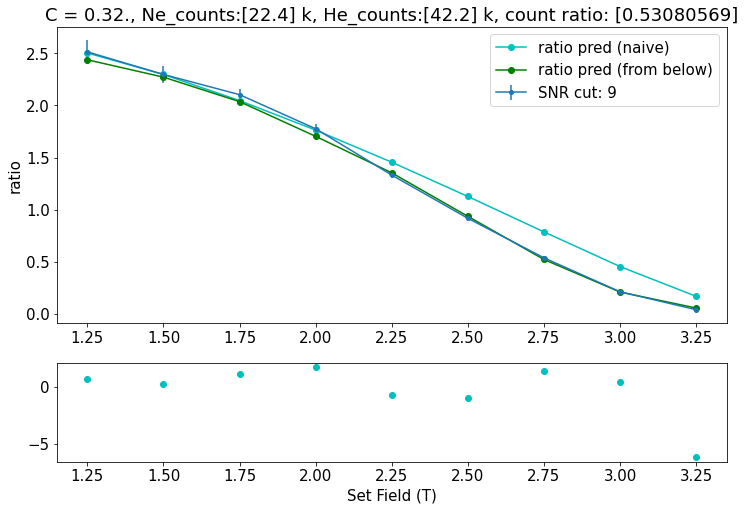

In [15]:
plt.rcParams.update({'font.size': 15})
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]},figsize=(12,8))

ne_counts = []
he_counts = []

for cut in snr_cuts: 

    ratio_exp = re.build_ratio_altnorm(snr_study_spectra["ne"][cut], snr_study_spectra["he"][cut])
    freq_BW = np.array([18.0e9 ,  19.1e9])

    freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

    ratio_pred_naive = rp.AUC_expectation(set_fields, freq_BWs, b = 0, plot = False)

    ratio_exp = ratio_exp[ratio_exp.index.isin(set_fields)]

    # Fit to the free normalization parameter. 
    def objfunc_chisq(C, ratio_pred, ratio_exp ): 

        # I think the lmfit does the least squares on these values for you but double check. 
        chisq_gauss = (ratio_pred["Ratio"] - C*ratio_exp["Ratio"])/ (C*ratio_exp["sRatio"])
        return chisq_gauss

    my_pars = Parameters()
    my_pars.add('C', value=1, min=0, max = 10, vary =True)

    result = minimize(objfunc_chisq, my_pars, args = (ratio_pred, ratio_exp))
    print(f"reduced chisq: {result.redchi}")
    C = result.params["C"].value
    ratio_exp["Ratio"] = C*ratio_exp["Ratio"]
    ratio_exp["sRatio"] = C*ratio_exp["sRatio"]

    pm.plot_experimental_ratio(ratio_exp, ax0, label= f"SNR cut: {cut}")

    if cut == 9: 
        ax0.plot(ratio_pred_naive.index, ratio_pred_naive.Ratio, color = 'c',
                 label = "ratio pred (naive)",
                marker="o", ms=6,)
        ax0.plot(ratio_pred.index, ratio_pred.Ratio, color = 'g',
                 label = "ratio pred (from below)",
                marker="o", ms=6,)

    ne_counts.append(snr_study_spectra["ne"][cut].event_count.sum().round(-2)/1000)
    he_counts.append(snr_study_spectra["he"][cut].event_count.sum().round(-2)/1000)
    count_ratio = np.array(ne_counts)/np.array(he_counts)

# ax0.set_yscale("log")
ax0.set_ylabel('ratio')
ax1.set_xlabel('Set Field (T)')
ax0.set_title(f"C = {C:.2f}., Ne_counts:{ne_counts} k, He_counts:{he_counts} k, count ratio: {count_ratio}")
ax0.legend()

ax1.plot(ratio_pred.index, (ratio_exp.Ratio - ratio_pred.Ratio)/ratio_exp.sRatio , 
         label= f"snr cut: {cut}", 
         marker="o", 
         ls = "None",
         ms=6, 
         color = "c")
plt.show()

## **Step 4: Effectiveness of Veto (More Ratio Plots)**

* MC work used here can be found here:  http://localhost:8888/lab/tree/He6CRES/rocks_analysis_notebooks/MC_thesis_studies.ipynb

**Notes**:
* Here I want to show that the ratio fails but how well does it do if you make an assumption about what's failing to be vetoed. Fit to this number and show that it's consistent for differnet start freq cuts? That may not be possible. 

In [16]:
both_cuts = {
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventStartTime": (.0001,np.inf),
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (0, np.inf),
            "mTotalSNR": (40,  np.inf),
            "mTotalPower": (0, np.inf), 
            "mTotalNUP": (0,np.inf),
            "mMaxSNR": (0,np.inf),
            "detectability": (0,np.inf), 
            "mMeanSNR": (0,np.inf),
            }

ne_cuts = both_cuts
he_cuts = both_cuts

### Plot Ratio with different veto cuts. 
 

In [17]:
# Set start and stop freqs for cuts. 
freq1s = np.arange(100,1100,100)
freq2s = np.arange(200,1200,100)
# freq2s = np.ones_like(freq1s)*1200
print(f"veto start_freqs: {freq1s}\nveto end_freqs: {freq2s}")
set_fields = np.arange(1.25,3.5,.25)
freq_BW = np.array([18.0e9,19.1e9])
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

veto start_freqs: [ 100  200  300  400  500  600  700  800  900 1000]
veto end_freqs: [ 200  300  400  500  600  700  800  900 1000 1100]


Spectrum cut: [100. 200.] MHz
BW used for predicted ratio:[1.80e+10 1.81e+10]
reduced chisq: 127.73151508950286



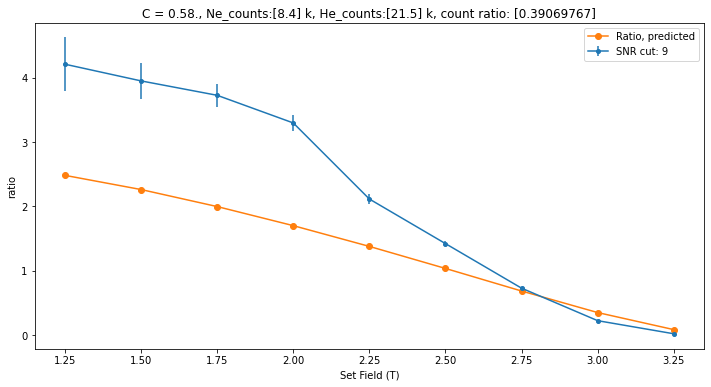

Spectrum cut: [200. 300.] MHz
BW used for predicted ratio:[1.81e+10 1.82e+10]
reduced chisq: 20.552576234674195



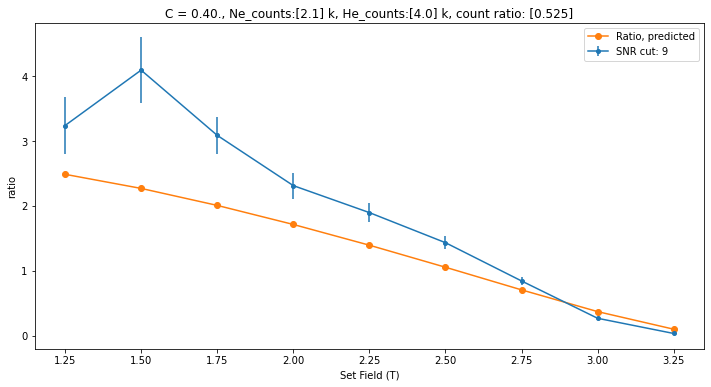

Spectrum cut: [300. 400.] MHz
BW used for predicted ratio:[1.82e+10 1.83e+10]
reduced chisq: 2.452117436240848



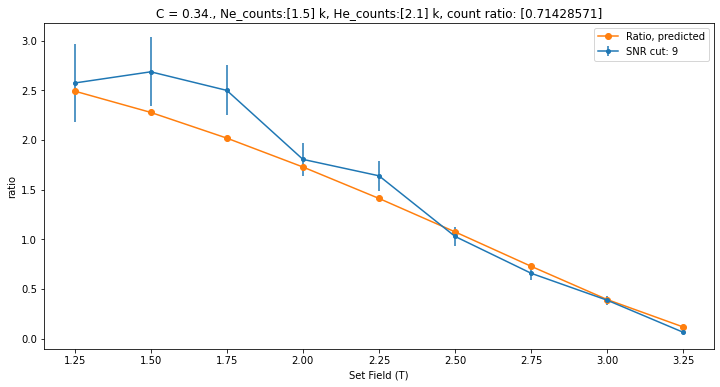

Spectrum cut: [400. 500.] MHz
BW used for predicted ratio:[1.83e+10 1.84e+10]
reduced chisq: 5.534527925434502



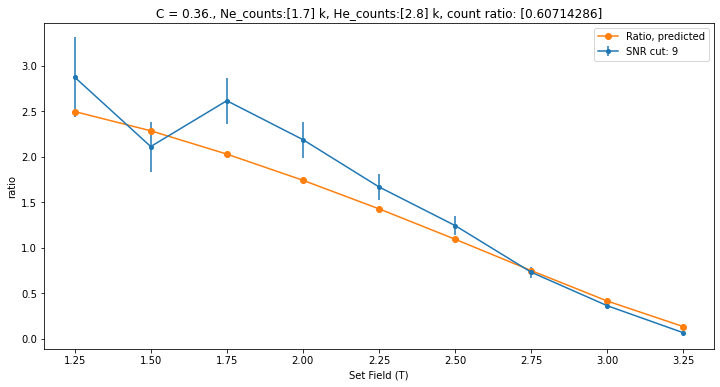

Spectrum cut: [500. 600.] MHz
BW used for predicted ratio:[1.84e+10 1.85e+10]
reduced chisq: 3.1493285514943805



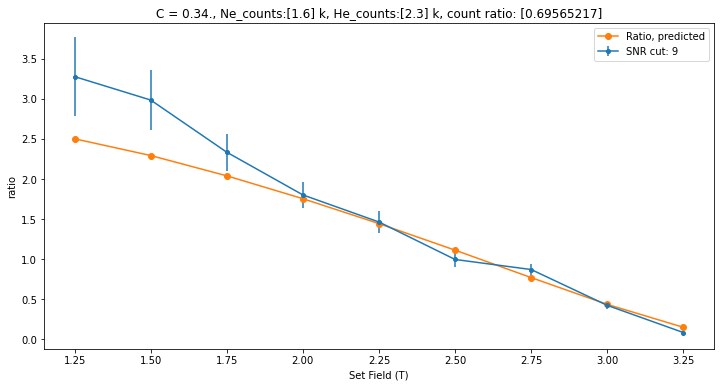

Spectrum cut: [600. 700.] MHz
BW used for predicted ratio:[1.85e+10 1.86e+10]
reduced chisq: 0.7084697063027151



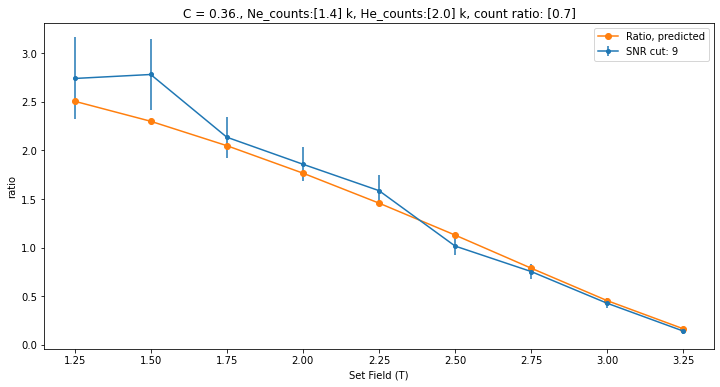

Spectrum cut: [700. 800.] MHz
BW used for predicted ratio:[1.86e+10 1.87e+10]
reduced chisq: 3.0929951301951277



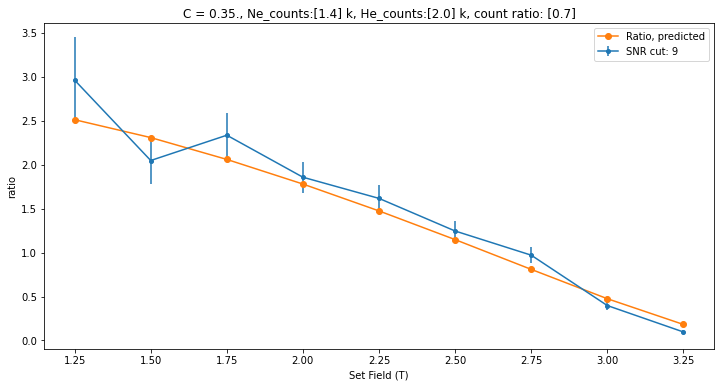

Spectrum cut: [800. 900.] MHz
BW used for predicted ratio:[1.87e+10 1.88e+10]
reduced chisq: 1.2238511587829937



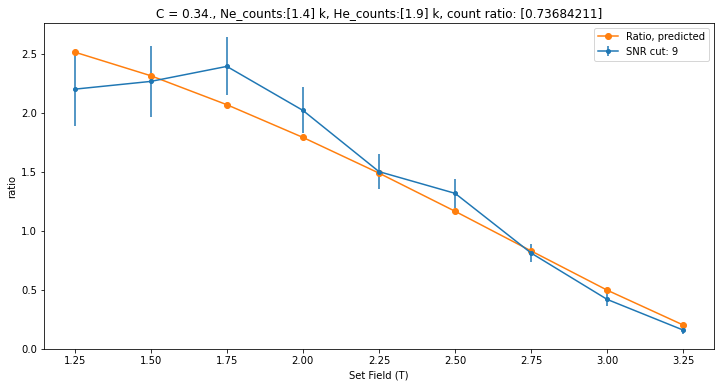

Spectrum cut: [ 900. 1000.] MHz
BW used for predicted ratio:[1.88e+10 1.89e+10]
reduced chisq: 1.4914361224674013



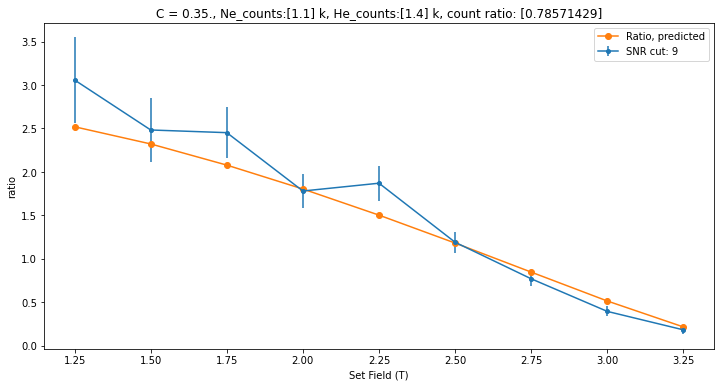

Spectrum cut: [1000. 1100.] MHz
BW used for predicted ratio:[1.89e+10 1.90e+10]
reduced chisq: 1.360482481688367



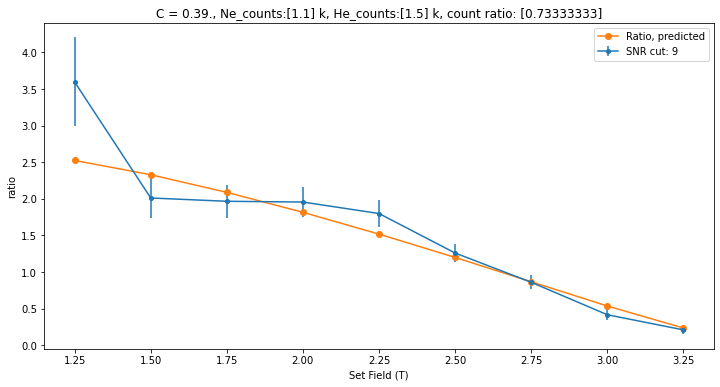

In [18]:
%matplotlib inline

plot_spectrum = False

for freq1, freq2 in zip(freq1s, freq2s):     
    spectrum_cuts = {
                "EventStartFreq": ((freq1)*1e6, (freq2)*1e6)
                }

    ne_cuts = {**both_cuts, **spectrum_cuts}
    he_cuts = {**both_cuts, **spectrum_cuts}

    ne_spectra = []
    he_spectra = []       
    
    for cut in snr_cuts:

        ne = snr_study["ne"][cut]
        ne_spectra.append(re.build_spectrum(ne.events.copy(), ne.root_files.copy(), ne_cuts))

        he = snr_study["he"][cut]
        he_spectra.append(re.build_spectrum(he.events.copy(), he.root_files.copy(), he_cuts))

    snr_study_spectra = { "ne": dict(zip(snr_cuts,ne_spectra)),
                          "he": dict(zip(snr_cuts,he_spectra))}
    
    if plot_spectrum: 
        fig, ax = plt.subplots(figsize=(12,6))
        for cut in snr_cuts:
            for isotope in snr_study_spectra.keys():
                snr_study_spectra[isotope][cut].plot(x = "set_field", y = "mon_adjusted_count", ax = ax, label = f"{cut}_{isotope}")
        plt.show()
    
    # Make the experimental ratio and fit to predicted.
    fig0, ax0 = plt.subplots(figsize=(12,6))
    
    ne_counts = []
    he_counts = []
    for cut in snr_cuts: 
        
        ratio_exp = re.build_ratio_altnorm(snr_study_spectra["ne"][cut], snr_study_spectra["he"][cut])

        # Make the predicted ratio.
        freq_BW = np.array([17.9e9 + spectrum_cuts["EventStartFreq"][0] ,  17.9e9 +  spectrum_cuts["EventStartFreq"][1]])
        print("Spectrum cut: {} MHz".format(np.array(spectrum_cuts["EventStartFreq"])/1e6))
        print(f"BW used for predicted ratio:{freq_BW}")

        freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

        ratio_pred = rp.AUC_expectation(set_fields, freq_BWs, b = 0, plot = False)
        
        # Only take the fields you want: 
        ratio_pred = ratio_pred[ratio_pred.index.isin(set_fields)]
        ratio_exp = ratio_exp[ratio_exp.index.isin(set_fields)]

        my_pars = Parameters()
        my_pars.add('C', value=1, min=0, max = 10, vary =True)
        my_pars.add('b', value=0, min=0, max = 10, vary =False)
        
        # Fit to just C, leave b fixed. 
        result = minimize(mc.objfunc_chisq, my_pars, args = (freq_BWs, set_fields, ratio_exp))
        print(f"reduced chisq: {result.redchi}\n")
        C = result.params["C"].value
        ratio_exp["Ratio"] = C*ratio_exp["Ratio"]
        ratio_exp["sRatio"] = C*ratio_exp["sRatio"]
        
        pm.plot_experimental_ratio(ratio_exp, ax0, label= f"SNR cut: {cut}")
        
        # Plot predicted ratio
        pm.plot_predicted_ratio(ratio_pred, ax0)

        ne_counts.append(snr_study_spectra["ne"][cut].event_count.sum().round(-2)/1000)
        he_counts.append(snr_study_spectra["he"][cut].event_count.sum().round(-2)/1000)
        count_ratio = np.array(ne_counts)/np.array(he_counts)
    
    # ax0.set_yscale("log")
    ax0.set_ylabel('ratio')
    ax0.set_xlabel('Set Field (T)')
    ax0.set_title(f"C = {C:.2f}., Ne_counts:{ne_counts} k, He_counts:{he_counts} k, count ratio: {count_ratio}")
    ax0.legend()
    plt.show()
    # print(np.array(spectrum_cuts["EventStartFreq"])/1e6)

## **Step 5: Why can't we successfully veto from below??**

* MC work used here can be found here:  http://localhost:8888/lab/tree/He6CRES/rocks_analysis_notebooks/MC_thesis_studies.ipynb

**Notes**:
* Here I want to try a field-wise SNR cut and a field-wise track length or "Fraction_covered". Maybe make this cut and then cut on start freq? Try it out. Be quick. Make it integrate into the cut_df method in a way that 
* See if it matters what order the cuts are applied (event-wise frist vs second)

In [19]:
both_cuts = {"field_wise":{
                "mMeanSNR":["median", (1,np.inf)],
                "EventTimeLength":["median", (-np.inf,np.inf)]},
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventStartTime": (.0001,np.inf),
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (0, np.inf),
            "mTotalSNR": (40,  np.inf),
            "mTotalPower": (0, np.inf), 
            "mTotalNUP": (0,np.inf),
            "mMaxSNR": (0,np.inf),
            "detectability": (0,np.inf), 
            "mMeanSNR": (0,np.inf),
            }

ne_cuts = both_cuts
he_cuts = both_cuts

### Plot Ratio with different veto cuts. 
 

In [20]:
# Set start and stop freqs for cuts. 
freq1s = np.arange(100,1100,100)
# freq2s = np.arange(200,1200,100)
freq2s = np.ones_like(freq1s)*1200
print(f"veto start_freqs: {freq1s}\nveto end_freqs: {freq2s}")
set_fields = np.arange(1.25,3.5,.25)
freq_BW = np.array([18.0e9,19.1e9])
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

veto start_freqs: [ 100  200  300  400  500  600  700  800  900 1000]
veto end_freqs: [1200 1200 1200 1200 1200 1200 1200 1200 1200 1200]


Spectrum cut: [ 100. 1200.] MHz
BW used for predicted ratio:[1.80e+10 1.91e+10]
reduced chisq: 110.02711135458856



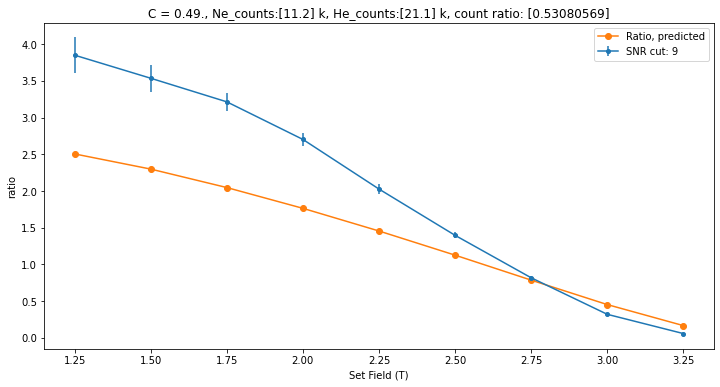

Spectrum cut: [ 200. 1200.] MHz
BW used for predicted ratio:[1.81e+10 1.91e+10]
reduced chisq: 4.079480599415099



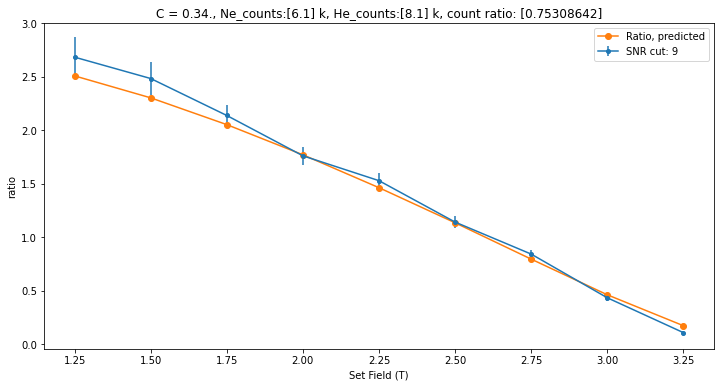

Spectrum cut: [ 300. 1200.] MHz
BW used for predicted ratio:[1.82e+10 1.91e+10]
reduced chisq: 2.071859815990549



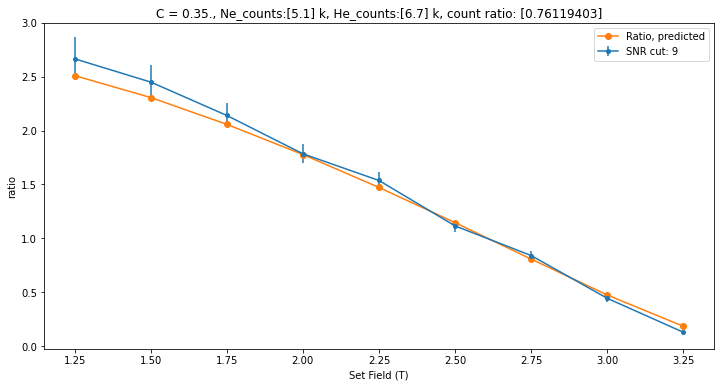

Spectrum cut: [ 400. 1200.] MHz
BW used for predicted ratio:[1.83e+10 1.91e+10]
reduced chisq: 1.8256951347872206



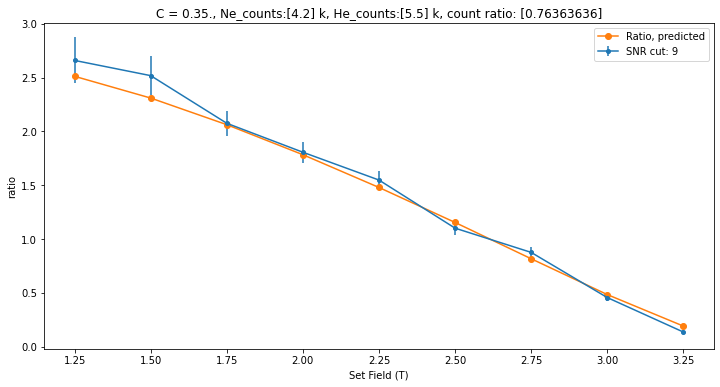

Spectrum cut: [ 500. 1200.] MHz
BW used for predicted ratio:[1.84e+10 1.91e+10]
reduced chisq: 1.994603731701833



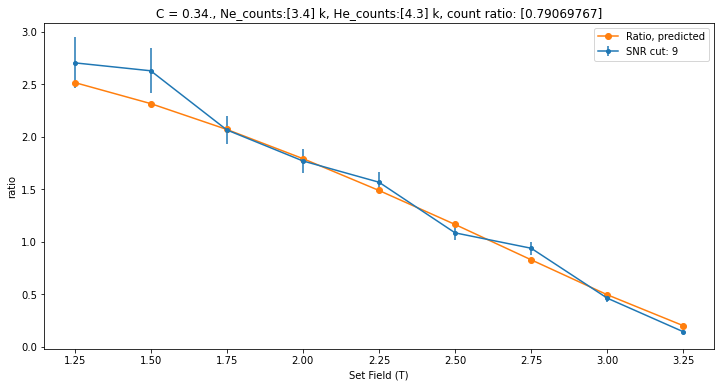

Spectrum cut: [ 600. 1200.] MHz
BW used for predicted ratio:[1.85e+10 1.91e+10]
reduced chisq: 0.8244717493440945



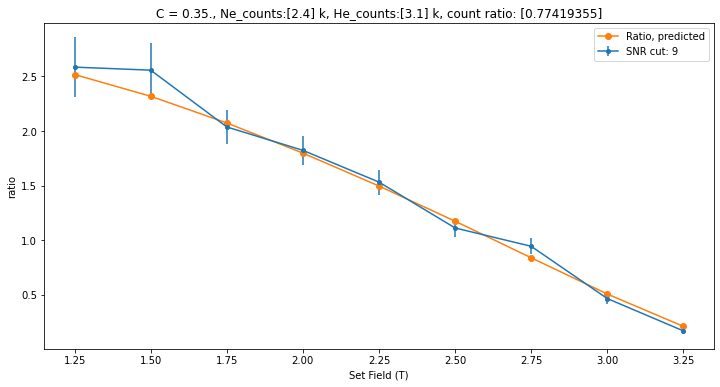

Spectrum cut: [ 700. 1200.] MHz
BW used for predicted ratio:[1.86e+10 1.91e+10]
reduced chisq: 1.0612143181731664



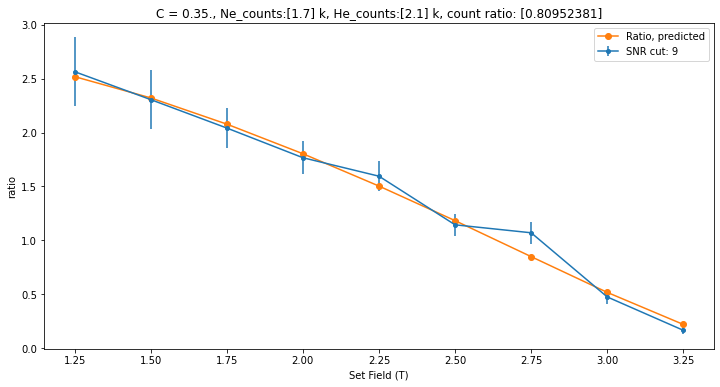

Spectrum cut: [ 800. 1200.] MHz
BW used for predicted ratio:[1.87e+10 1.91e+10]
reduced chisq: 1.0031694276637548



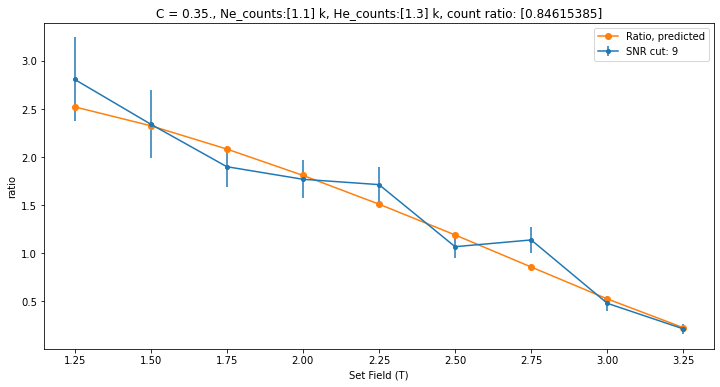

Spectrum cut: [ 900. 1200.] MHz
BW used for predicted ratio:[1.88e+10 1.91e+10]
reduced chisq: 1.4172002547097404



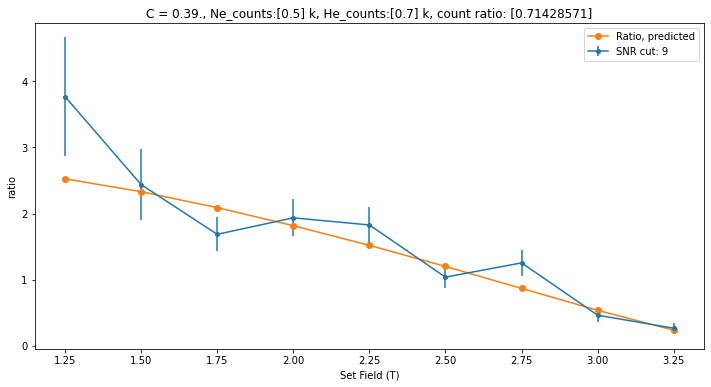

Spectrum cut: [1000. 1200.] MHz
BW used for predicted ratio:[1.89e+10 1.91e+10]
reduced chisq: 0.6414244335918267



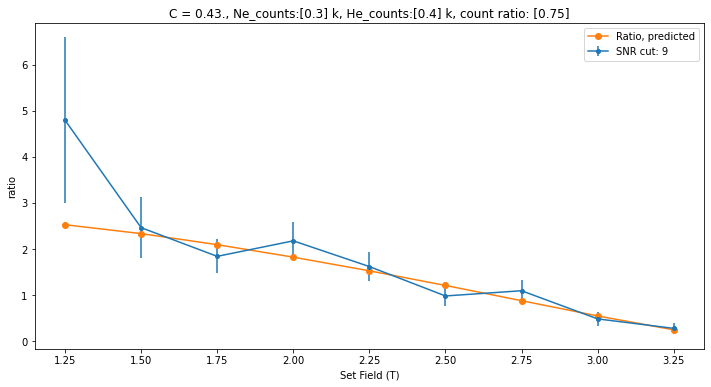

In [21]:
%matplotlib inline

plot_spectrum = False

for freq1, freq2 in zip(freq1s, freq2s):     
    spectrum_cuts = {
                "EventStartFreq": ((freq1)*1e6, (freq2)*1e6)
                }

    ne_cuts = {**both_cuts, **spectrum_cuts}
    he_cuts = {**both_cuts, **spectrum_cuts}

    ne_spectra = []
    he_spectra = []       
    
    for cut in snr_cuts:

        ne = snr_study["ne"][cut]
        ne_spectra.append(re.build_spectrum(ne.events.copy(), ne.root_files.copy(), ne_cuts))

        he = snr_study["he"][cut]
        he_spectra.append(re.build_spectrum(he.events.copy(), he.root_files.copy(), he_cuts))

    snr_study_spectra = { "ne": dict(zip(snr_cuts,ne_spectra)),
                          "he": dict(zip(snr_cuts,he_spectra))}
    
    if plot_spectrum: 
        fig, ax = plt.subplots(figsize=(12,6))
        for cut in snr_cuts:
            for isotope in snr_study_spectra.keys():
                snr_study_spectra[isotope][cut].plot(x = "set_field", y = "mon_adjusted_count", ax = ax, label = f"{cut}_{isotope}")
        plt.show()
    
    # Make the experimental ratio and fit to predicted.
    fig0, ax0 = plt.subplots(figsize=(12,6))
    
    ne_counts = []
    he_counts = []
    for cut in snr_cuts: 
        
        ratio_exp = re.build_ratio_altnorm(snr_study_spectra["ne"][cut], snr_study_spectra["he"][cut])

        # Make the predicted ratio.
        freq_BW = np.array([17.9e9 + spectrum_cuts["EventStartFreq"][0] ,  17.9e9 +  spectrum_cuts["EventStartFreq"][1]])
        print("Spectrum cut: {} MHz".format(np.array(spectrum_cuts["EventStartFreq"])/1e6))
        print(f"BW used for predicted ratio:{freq_BW}")

        freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

        ratio_pred = rp.AUC_expectation(set_fields, freq_BWs, b = 0, plot = False)
        
        # Only take the fields you want: 
        ratio_pred = ratio_pred[ratio_pred.index.isin(set_fields)]
        ratio_exp = ratio_exp[ratio_exp.index.isin(set_fields)]

        my_pars = Parameters()
        my_pars.add('C', value=1, min=0, max = 10, vary =True)
        my_pars.add('b', value=0, min=0, max = 10, vary =False)
        
        # Fit to just C, leave b fixed. 
        result = minimize(mc.objfunc_chisq, my_pars, args = (freq_BWs, set_fields, ratio_exp))
        print(f"reduced chisq: {result.redchi}\n")
        C = result.params["C"].value
        ratio_exp["Ratio"] = C*ratio_exp["Ratio"]
        ratio_exp["sRatio"] = C*ratio_exp["sRatio"]
        
        pm.plot_experimental_ratio(ratio_exp, ax0, label= f"SNR cut: {cut}")
        
        # Plot predicted ratio
        pm.plot_predicted_ratio(ratio_pred, ax0)

        ne_counts.append(snr_study_spectra["ne"][cut].event_count.sum().round(-2)/1000)
        he_counts.append(snr_study_spectra["he"][cut].event_count.sum().round(-2)/1000)
        count_ratio = np.array(ne_counts)/np.array(he_counts)
    
    # ax0.set_yscale("log")
    ax0.set_ylabel('ratio')
    ax0.set_xlabel('Set Field (T)')
    ax0.set_title(f"C = {C:.2f}., Ne_counts:{ne_counts} k, He_counts:{he_counts} k, count ratio: {count_ratio}")
    ax0.legend()
    plt.show()
    # print(np.array(spectrum_cuts["EventStartFreq"])/1e6)

In [22]:
def cut_df(events, cuts, plot_fw_cuts = False):
    
    # Make a copy of events to alter and return.
    events_cut = events.copy()
    
    # Note that the None prevents a key error if you have no field-wise cuts. 
    field_wise_cuts = cuts.pop("field_wise", None)
    
    if field_wise_cuts is not None: 
        for column, cut in field_wise_cuts.items():

            events_cut["cut_cond"] = events.groupby(["set_field"])[column].transform(cut[0])
            if plot_fw_cuts: 
                events_cut["cut_cond"].plot()
                plt.show()

            cond = ((events_cut[column] >= cut[1][0]*events_cut["cut_cond"]) & 
                    (events_cut[column] <= cut[1][1]*events_cut["cut_cond"]))

            events_cut = events_cut[cond]

    for column, cut in cuts.items():

        events_cut = events_cut[
            (events_cut[column] >= cut[0]) & (events_cut[column] <= cut[1])
        ]

    return events_cut

In [23]:
cuts = {
            "field_wise":{
                "mMeanSNR":["median", (.9,np.inf)],
                "EventTimeLength":["median", (1,np.inf)]},
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            }
cuts = {
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            }
events = snr_study["ne"][9].events
print(events.columns)
display(events.groupby("set_field").EventID.count())
events_cut = cut_df(events, cuts)
display(events_cut.groupby("set_field").EventID.count())

Index(['run_id', 'file_id', 'EventID', 'EventStartTime', 'EventEndTime',
       'EventStartFreq', 'EventEndFreq', 'EventTimeLength', 'EventFreqLength',
       'EventTrackCoverage', 'EventSlope', 'EventNBins', 'EventTrackTot',
       'EventFreqIntc', 'EventTimeIntc', 'mMeanSNR', 'sMeanSNR', 'mTotalSNR',
       'sTotalSNR', 'mMaxSNR', 'sMaxSNR', 'mTotalNUP', 'sTotalNUP',
       'mTotalPower', 'sTotalPower', 'field', 'set_field', 'monitor_rate'],
      dtype='object')


set_field
0.75      56
1.00     731
1.25    1517
1.50    1955
1.75    3106
2.00    3804
2.25    3378
2.50    3746
2.75    3011
3.00    1420
3.25     226
Name: EventID, dtype: int64

set_field
0.75      56
1.00     731
1.25    1517
1.50    1955
1.75    3106
2.00    3804
2.25    3378
2.50    3746
2.75    3011
3.00    1420
3.25     226
Name: EventID, dtype: int64

In [ ]:
# display(events)

display(events.groupby("set_field").EventID.count())
events["stuff"] = events.groupby(["set_field"])[
            "mMeanSNR"
        ].transform("median")
display(events.stuff.plot())
plt.show()
events_cut = events[events["mMeanSNR"] > events["stuff"]]

display(events_cut.groupby("set_field").EventID.count())
display(events_cut.groupby("set_field").EventID.count()/events.groupby("set_field").EventID.count())
# df.groupby('column').filter(lambda group: group.size > X)

set_field
0.75      56
1.00     731
1.25    1517
1.50    1955
1.75    3106
2.00    3804
2.25    3378
2.50    3746
2.75    3011
3.00    1420
3.25     226
Name: EventID, dtype: int64

## **Step 6: Energy domain plot**

**Notes**:
* Here I want to show the energy domain plot. You basically have this but make it work again here and make the plot nice with the pdf.    

In [ ]:
both_cuts = {"field_wise":{
                "mMeanSNR":["median", (1.0,np.inf)],
                "EventTimeLength":["median", (-np.inf,np.inf)]},
            "EventStartFreq": (0e6, 1200e6),
            "EventNBins": (0, np.inf), 
            "EventStartTime": (.0001,np.inf),
            "EventTimeLength": (0,.05),
            "EventTimeIntc": (-.5e7,np.inf),
            "EventFreqIntc": (-2e11,np.inf),
            "EventSlope": (.01e10, np.inf),
            "EventTrackCoverage": (0, np.inf),
            "mTotalSNR": (40,  np.inf),
            "mTotalPower": (0, np.inf), 
            "mTotalNUP": (0,np.inf),
            "mMaxSNR": (0,np.inf),
            "detectability": (0,np.inf), 
            "mMeanSNR": (0,np.inf),
            }

In [ ]:
%matplotlib inline

# Plot results.
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]},figsize=(12,8))

set_fields = np.arange(1.25,3.5,.25)
snr_cuts = [9]
mixer_freq = 17.9e9
b=0

b_fits = []
b_errs = []

# Feed the info dict to the BetaSpectrum class.
isotopes = {"Ne19": {"b": -0.7204 * b}, "He6": {"b": b}}
bspec = bs.BetaSpectrum("Ne19", b = 0)


Ws = np.linspace(1.001, bspec.W0-.001, 300)
pdf = bspec.dNdE(Ws)

# for (freq1, freq2) in zip(np.arange(100,1100, 100),np.arange(300,1300, 100)):

freq_BW_full = np.array([18.2e9 ,  19.1e9])
freq_BW_tot = freq_BW_full[1] - freq_BW_full[0]
freq_chunk = 450e6
n_chunks = int(np.ceil((freq_BW_tot / freq_chunk)))
print(n_chunks)

b_fits = []
b_errs = []

for i,chunk in enumerate(range(n_chunks)):
    
    freq_BW = np.clip(np.array([freq_BW_full[0]+ freq_chunk*chunk, freq_BW_full[0]+ freq_chunk*(chunk+1)]), 
                      0,freq_BW_full.max())
        
    spectrum_cuts = {
                "EventStartFreq": (freq_BW[0]- mixer_freq, freq_BW[1]-mixer_freq)
                }
    print([spectrum_cuts["EventStartFreq"][0] ,  spectrum_cuts["EventStartFreq"][1]])
    ne_cuts = {**both_cuts, **spectrum_cuts}
    he_cuts = {**both_cuts, **spectrum_cuts}

    ne_spectra = []
    he_spectra = []       
    
    for cut in snr_cuts:
        
        ne = snr_study["ne"][cut]
        
        ne_spectra.append(re.build_spectrum(ne.events.copy(), ne.root_files.copy(), ne_cuts))

        he = snr_study["he"][cut]
        he_spectra.append(re.build_spectrum(he.events.copy(), he.root_files.copy(), he_cuts))

    snr_study_spectra = { "ne": dict(zip(snr_cuts,ne_spectra)),
                          "he": dict(zip(snr_cuts,he_spectra))}


    ne_counts = []
    he_counts = []
    for cut in snr_cuts: 
        
        ratio_exp = re.build_ratio_altnorm(snr_study_spectra["ne"][cut], snr_study_spectra["he"][cut])

        # Make the predicted ratio.
        freq_BW = np.array([mixer_freq+ spectrum_cuts["EventStartFreq"][0] ,  mixer_freq + spectrum_cuts["EventStartFreq"][1]])
        print(freq_BW)
        freq_BWs = np.tile(freq_BW, (len(set_fields), 1))
        print(freq_BWs)

        ratio_exp = ratio_exp[ratio_exp.index.isin(set_fields)]


            # Conduct fit. 
        my_pars = Parameters()
        my_pars.add('C', value=1, min=-100, max = 100, vary =True)
        my_pars.add('b', value=0, min=-10, max = 10, vary =False)

        result = minimize(we.objfunc_chisq, my_pars, args = (freq_BWs, set_fields, ratio_exp))

        # Fit report.
        print(fit_report(result.params))

        C = result.params["C"].value
        b = result.params["b"].value

        # Get the SM prediction.
        ratio_pred = we.AUC_expectation_we(set_fields, freq_BWs, b = b, plot = False, wall_effect = False)

        ratio_corr = ratio_exp.copy()
        ratio_corr["Ne19_corr"] = C*ratio_pred["He6"]*ratio_exp["Ratio"]
        ratio_corr["sNe19_corr"] = C*ratio_pred["He6"]*ratio_exp["sRatio"]

        gamma_acceptances, gamma_widths, gamma_heights, gamma_height_errs, SM_heights = ed.freq_to_energy_domain(
        set_fields, freq_BWs, ratio_corr, ratio_pred)

        label_bool = i==0
        ed.energy_domain_plot(ax0,ax1, gamma_acceptances, gamma_widths, 
                              gamma_heights, gamma_height_errs, SM_heights, 
                              ratio_corr, ratio_pred, label = label_bool) 

        # Now add to the list of b_normed

        b_fits.append(result.params["b"].value)
        b_errs.append(result.params["b"].stderr)
        
        fig, ax = plt.subplots(figsize=(12,6))
            # Plot the experimental ratio. 
        ax.errorbar(
        ratio_corr.index,
        C*ratio_corr.Ratio,
        yerr=C*ratio_corr.sRatio,
        label=f"snr cut: {cut}",
        marker="o",
        ls = "None",
        ms=4, 
        alpha = 1, 
        color = "b")
        
        ax.plot(ratio_pred.index, ratio_pred.Ratio, label= "predicted", color = "b", alpha = .5 )

ax0.plot(Ws, pdf, label = "pdf")


ax0.legend()
ax1.legend()

ax0.set_xlim(.85,5.5); ax1.set_xlim(.85,5.5)
plt.show()

### 